In [2]:
# Instalar dependencias necesarias
!pip install mlflow dagshub --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
# 1. Configuración del entorno e importaciones
# --------------------------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.data
import mlflow.sklearn

In [4]:
# -------------------- CONFIGURACIÓN MLFLOW --------------------

# Finalizar cualquier sesión de MLflow activa
try:
    mlflow.end_run()
    print("Sesión anterior de MLflow finalizada")
except:
    pass

# Configurar MLflow
try:
    print("Configurando MLflow...")
    os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow'
    os.environ['MLFLOW_TRACKING_USERNAME'] = 'AngelBReal'

    # Solo solicita el token si no está configurado
    if 'MLFLOW_TRACKING_PASSWORD' not in os.environ:
        os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Token DagsHub: ')

    # Configurar URI
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
    print(f"URI de tracking: {mlflow.get_tracking_uri()}")
except Exception as e:
    print(f"Error en configuración remota: {e}")
    print("Usando MLflow en modo local")
    mlflow.set_tracking_uri(None)

Sesión anterior de MLflow finalizada
Configurando MLflow...
Token DagsHub: ··········
URI de tracking: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow


In [13]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# Cargar dataset
print("\nCargando dataset...")
df = pd.read_csv("/content/classical_models.csv")
print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Separar variables
y = df['label']
X_text = df['combined_text']
X_num = df.select_dtypes(include=[np.number])

# Limpiar valores faltantes
df_clean = df.dropna(subset=['label'])
X = df_clean.drop(columns=['label', 'combined_text', 'clean_title', 'clean_content', 'content', 'title'])
y = df_clean['label']
text_data = df_clean['combined_text']

# Imputar solo columnas numéricas
X_num = X.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
X_num_imputed = imputer.fit_transform(X_num)
print(f"Valores faltantes imputados en las características numéricas")

# Eliminar columnas constantes
var_selector = VarianceThreshold(threshold=0.0)
X_num_reduced = var_selector.fit_transform(X_num_imputed)
kept_columns = X_num.columns[var_selector.get_support()]
print(f"Columnas numéricas mantenidas ({len(kept_columns)}): {list(kept_columns)}")

# Seleccionar mejores características numéricas (opcional)
k = min(20, X_num_reduced.shape[1])
selector = SelectKBest(score_func=f_classif, k=k)
X_num_selected = selector.fit_transform(X_num_reduced, y)
print(f"Seleccionadas las {k} mejores características numéricas")

# Dividir texto y numérico juntos
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    text_data, X_num_selected, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF solo en entrenamiento
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 3), min_df=2, max_df=0.85)
X_text_train_tfidf = tfidf.fit_transform(X_text_train)
X_text_test_tfidf = tfidf.transform(X_text_test)
print(f"TF-IDF aplicado: train {X_text_train_tfidf.shape}, test {X_text_test_tfidf.shape}")

# Combinar TF-IDF + numéricas
X_train_combined = np.hstack((X_text_train_tfidf.toarray(), X_num_train))
X_test_combined = np.hstack((X_text_test_tfidf.toarray(), X_num_test))
print(f"Datos combinados: train {X_train_combined.shape}, test {X_test_combined.shape}")

# Escalar características (solo numéricas, opcional si necesario)
scaler = StandardScaler()
X_train_combined[:, -k:] = scaler.fit_transform(X_train_combined[:, -k:])
X_test_combined[:, -k:] = scaler.transform(X_test_combined[:, -k:])

print("Pipeline listo para entrenamiento de modelos.")


Cargando dataset...
Dataset cargado: 3063 filas, 375 columnas
Valores faltantes imputados en las características numéricas
Columnas numéricas mantenidas (11): ['title_word_count', 'content_word_count', 'num_uppercase_words', 'has_known_source', 'fake_word_in_title', 'exclam_density', 'title_length', 'content_length', 'title_sensational_count', 'content_sensational_count', 'title_uppercase_ratio']
Seleccionadas las 11 mejores características numéricas
TF-IDF aplicado: train (2450, 15000), test (613, 15000)
Datos combinados: train (2450, 15011), test (613, 15011)
Pipeline listo para entrenamiento de modelos.


Experimento configurado: Regresión Noticias Falsas
Total de modelos a probar: 30

=== Probando modelo: LinearRegression ===

Combinación 1/30: {}
Entrenando modelo...
MSE: 0.203015, RMSE: 0.450572, MAE: 0.366065, R²: 0.050806


2025/05/05 08:07:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


¡Nuevo mejor modelo encontrado!
🏃 View run LinearRegression at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/b2a498d7b15f4a8fac84bd4e0b3f665b
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

=== Probando modelo: Ridge ===

Combinación 2/30: {'alpha': 0.01, 'solver': 'auto'}
Entrenando modelo...
MSE: 0.186482, RMSE: 0.431836, MAE: 0.353639, R²: 0.128104


2025/05/05 08:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


¡Nuevo mejor modelo encontrado!
🏃 View run Ridge - {'alpha': 0.01, 'solver': 'auto'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/3ca82606ddf84598bdd606ac85ce36db
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 3/30: {'alpha': 0.01, 'solver': 'svd'}
Entrenando modelo...
MSE: 0.186482, RMSE: 0.431836, MAE: 0.353639, R²: 0.128104


2025/05/05 08:09:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 0.01, 'solver': 'svd'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/135b03ef80e34a23b428b04b256d8176
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 4/30: {'alpha': 0.01, 'solver': 'cholesky'}
Entrenando modelo...
MSE: 0.186482, RMSE: 0.431836, MAE: 0.353639, R²: 0.128104


2025/05/05 08:09:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 0.01, 'solver': 'cholesky'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/8f30e32647484e2ab74c0fd00d0d4489
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 5/30: {'alpha': 0.1, 'solver': 'auto'}
Entrenando modelo...
MSE: 0.172492, RMSE: 0.415322, MAE: 0.340685, R²: 0.193514


2025/05/05 08:09:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


¡Nuevo mejor modelo encontrado!
🏃 View run Ridge - {'alpha': 0.1, 'solver': 'auto'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/5d1cc987692844dbbbbb6557f1818bca
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 6/30: {'alpha': 0.1, 'solver': 'svd'}
Entrenando modelo...
MSE: 0.172492, RMSE: 0.415322, MAE: 0.340685, R²: 0.193514


2025/05/05 08:11:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


¡Nuevo mejor modelo encontrado!
🏃 View run Ridge - {'alpha': 0.1, 'solver': 'svd'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/4b05b17e65fb4ab397b6e3a1df76b823
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 7/30: {'alpha': 0.1, 'solver': 'cholesky'}
Entrenando modelo...
MSE: 0.172492, RMSE: 0.415322, MAE: 0.340685, R²: 0.193514


2025/05/05 08:11:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 0.1, 'solver': 'cholesky'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/10118f2a0700409997c90325c459e8e2
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 8/30: {'alpha': 1.0, 'solver': 'auto'}
Entrenando modelo...
MSE: 0.152562, RMSE: 0.390591, MAE: 0.331231, R²: 0.286700


2025/05/05 08:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


¡Nuevo mejor modelo encontrado!
🏃 View run Ridge - {'alpha': 1.0, 'solver': 'auto'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/ed90ad8f294f4837962636442715f0b5
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 9/30: {'alpha': 1.0, 'solver': 'svd'}
Entrenando modelo...
MSE: 0.152562, RMSE: 0.390591, MAE: 0.331231, R²: 0.286700


2025/05/05 08:12:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 1.0, 'solver': 'svd'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/99770c42762b47388682e68c3baea675
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 10/30: {'alpha': 1.0, 'solver': 'cholesky'}
Entrenando modelo...
MSE: 0.152562, RMSE: 0.390591, MAE: 0.331231, R²: 0.286700


2025/05/05 08:12:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 1.0, 'solver': 'cholesky'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/ae84c61b4f184ba0bb856a27d441567e
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 11/30: {'alpha': 10.0, 'solver': 'auto'}
Entrenando modelo...
MSE: 0.170080, RMSE: 0.412407, MAE: 0.365972, R²: 0.204795


2025/05/05 08:13:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
<ipython-input-14-d772038bddfa>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))


🏃 View run Ridge - {'alpha': 10.0, 'solver': 'auto'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/205b82fb377848b383ae3539611d86cb
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 12/30: {'alpha': 10.0, 'solver': 'svd'}
Entrenando modelo...
MSE: 0.170080, RMSE: 0.412407, MAE: 0.365972, R²: 0.204795


2025/05/05 08:14:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 10.0, 'solver': 'svd'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/d2180389111545b5a3c6106c060aa018
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 13/30: {'alpha': 10.0, 'solver': 'cholesky'}
Entrenando modelo...
MSE: 0.170080, RMSE: 0.412407, MAE: 0.365972, R²: 0.204795


2025/05/05 08:14:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge - {'alpha': 10.0, 'solver': 'cholesky'} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/1f108b3b275e4fccab8bd61c3a6ab07f
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

=== Probando modelo: Lasso ===

Combinación 14/30: {'alpha': 0.01, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.197716, RMSE: 0.444653, MAE: 0.401320, R²: 0.075581


2025/05/05 08:14:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 0.01, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/826536bb1b80483a988204ea724a5346
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 15/30: {'alpha': 0.01, 'max_iter': 3000}
Entrenando modelo...
MSE: 0.197716, RMSE: 0.444653, MAE: 0.401320, R²: 0.075581


2025/05/05 08:15:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 0.01, 'max_iter': 3000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/805c10d683d642e6970a786a07bb95e8
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 16/30: {'alpha': 0.1, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:15:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 0.1, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/5ddb26cc0e7246c18f8907d02237ad83
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 17/30: {'alpha': 0.1, 'max_iter': 3000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:15:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 0.1, 'max_iter': 3000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/43967e9ca1074f20b637ebe37e804b16
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 18/30: {'alpha': 1.0, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:16:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 1.0, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/b8bd51b4101243968d52c68eb114f58b
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 19/30: {'alpha': 1.0, 'max_iter': 3000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:16:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 1.0, 'max_iter': 3000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/44df74bb7cac4a4fab40eaf76e0b2a5f
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 20/30: {'alpha': 10.0, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:16:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 10.0, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/13a88dbe9cb24e1397797771649695de
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 21/30: {'alpha': 10.0, 'max_iter': 3000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:16:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso - {'alpha': 10.0, 'max_iter': 3000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/b823c8aa28864f8d988fd83cfabb003c
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

=== Probando modelo: ElasticNet ===

Combinación 22/30: {'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.196786, RMSE: 0.443605, MAE: 0.398281, R²: 0.079932


2025/05/05 08:17:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/8f13045ccaa741c48dde672ec318bc6a
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 23/30: {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.197209, RMSE: 0.444082, MAE: 0.399559, R²: 0.077952


2025/05/05 08:17:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 0.01, 'l1_ratio': 0.5, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/5ad9ce8395df4c78a16067797654b77f
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 24/30: {'alpha': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.197512, RMSE: 0.444423, MAE: 0.400628, R²: 0.076537


2025/05/05 08:17:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 0.01, 'l1_ratio': 0.8, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/694d084f7d0b4132b65d072d944fba35
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 25/30: {'alpha': 0.1, 'l1_ratio': 0.2, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.199430, RMSE: 0.446575, MAE: 0.406538, R²: 0.067569


2025/05/05 08:18:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 0.1, 'l1_ratio': 0.2, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/b8732820616a4911af3d283ba39ff159
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 26/30: {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.204045, RMSE: 0.451713, MAE: 0.415394, R²: 0.045990


2025/05/05 08:18:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/f8204daeda24400890214a8c68498a3e
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 27/30: {'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.211068, RMSE: 0.459422, MAE: 0.424517, R²: 0.013153


2025/05/05 08:18:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/28f8c1f6f9b945fbbdff202dd3b796cf
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 28/30: {'alpha': 1.0, 'l1_ratio': 0.2, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:18:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 1.0, 'l1_ratio': 0.2, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/5ba40e5bd43c4f28a7efbeef51821dfe
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 29/30: {'alpha': 1.0, 'l1_ratio': 0.5, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:19:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 1.0, 'l1_ratio': 0.5, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/82a3219ded904af2aa88acd0688478f1
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Combinación 30/30: {'alpha': 1.0, 'l1_ratio': 0.8, 'max_iter': 1000}
Entrenando modelo...
MSE: 0.213882, RMSE: 0.462473, MAE: 0.427549, R²: -0.000001


2025/05/05 08:19:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet - {'alpha': 1.0, 'l1_ratio': 0.8, 'max_iter': 1000} at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/3dd7ba6e7d174f90ac1cfe790a1b2e0e
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

=== MEJOR MODELO ENCONTRADO ===
Tipo: Ridge, Parámetros: {'alpha': 1.0, 'solver': 'auto'}, R²: 0.286700


2025/05/05 08:19:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Modelos Lineales V2 at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4/runs/6b458c375cdb4635b526eadf1b83b4ef
🧪 View experiment at: https://dagshub.com/AngelBReal/DeAMentis-AAA.mlflow/#/experiments/4

Proceso completado.


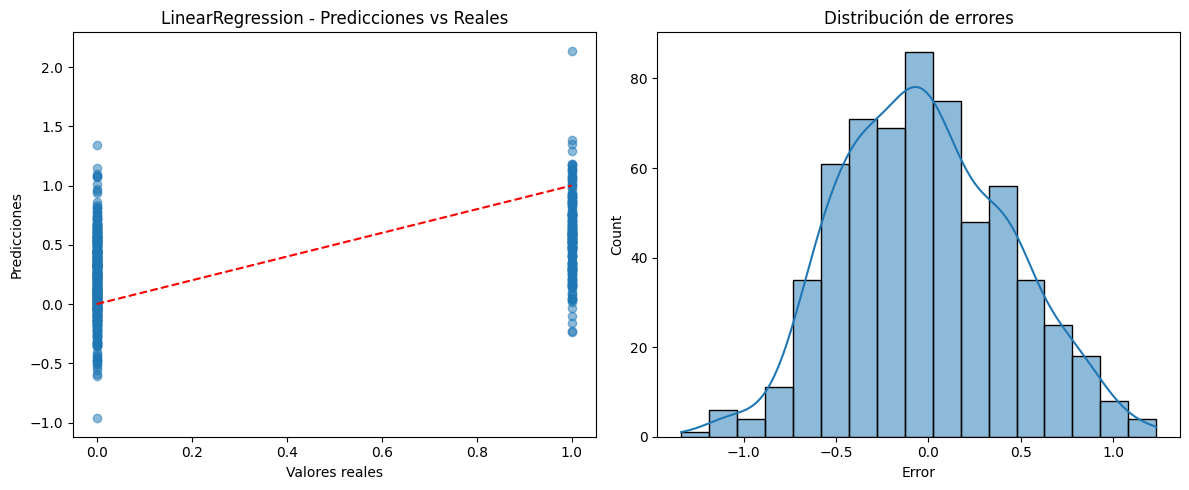

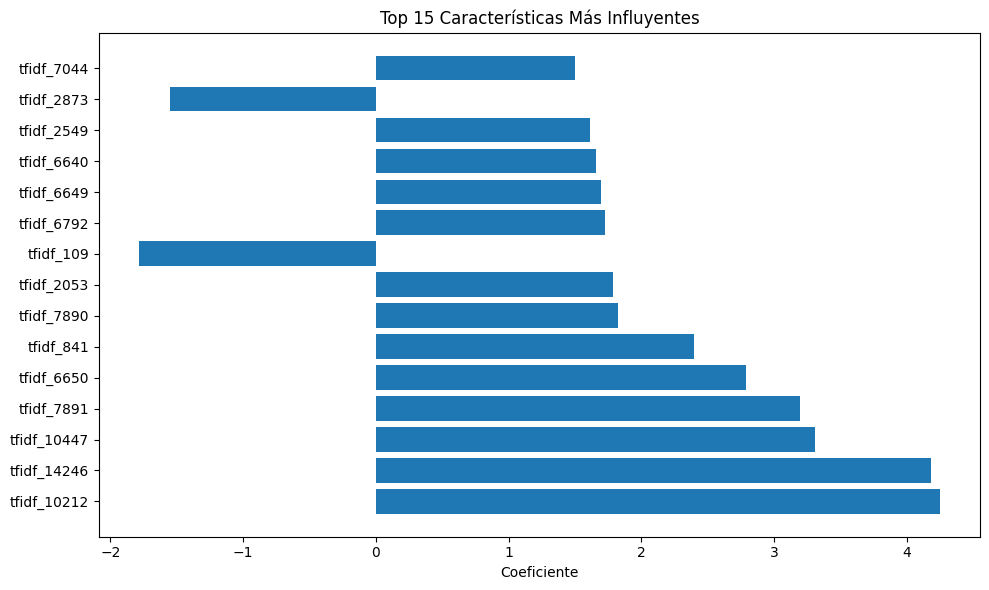

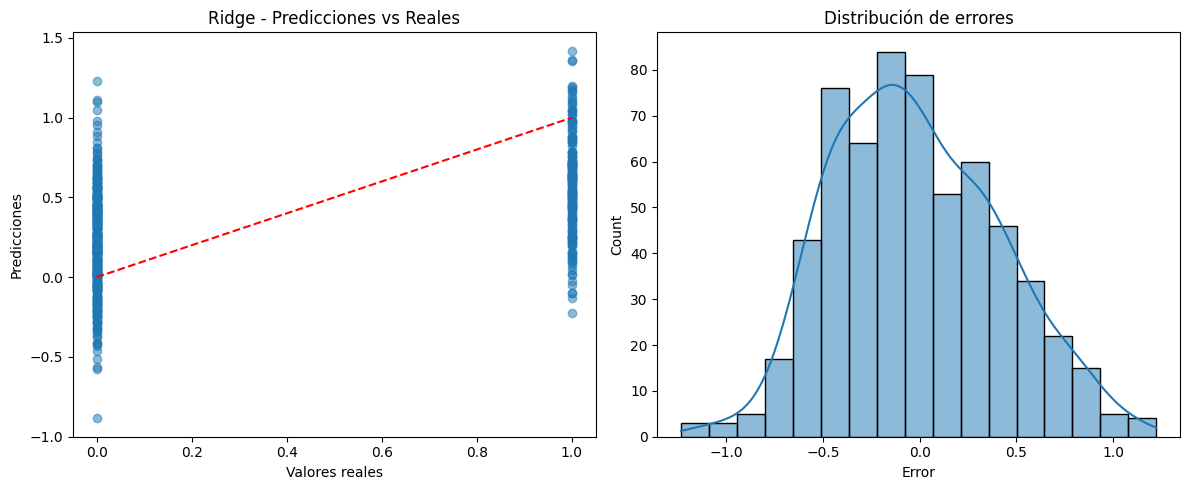

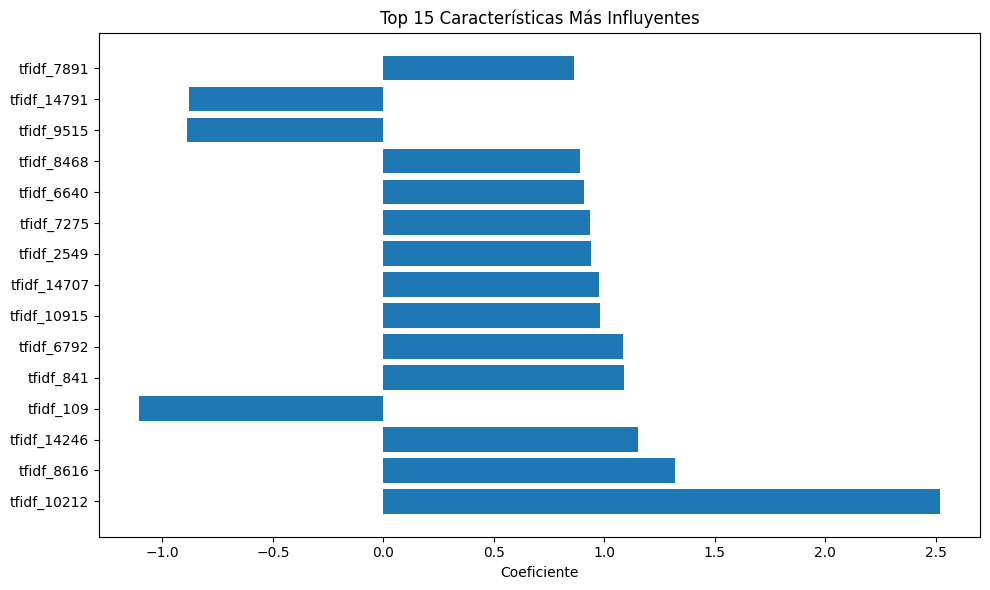

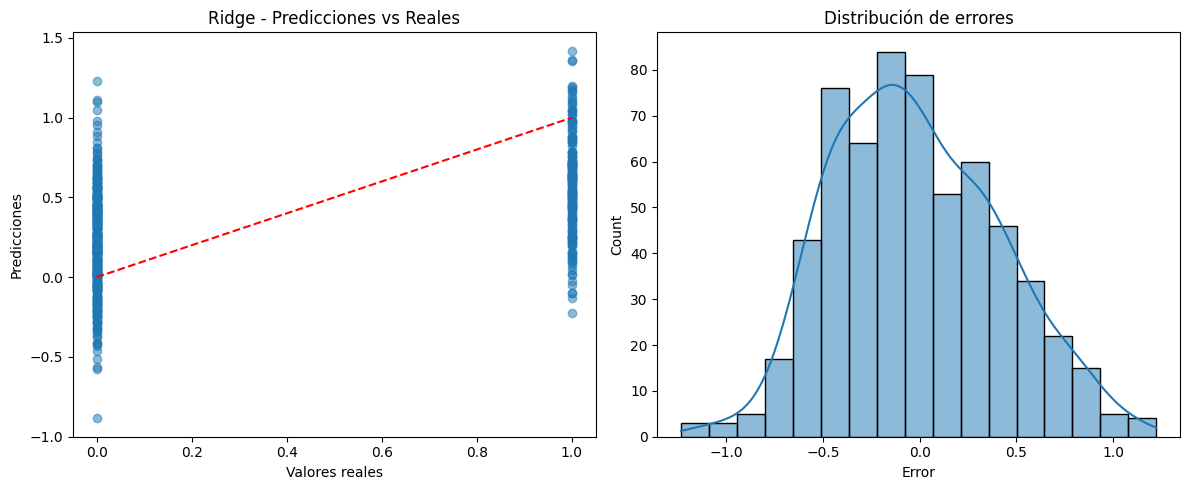

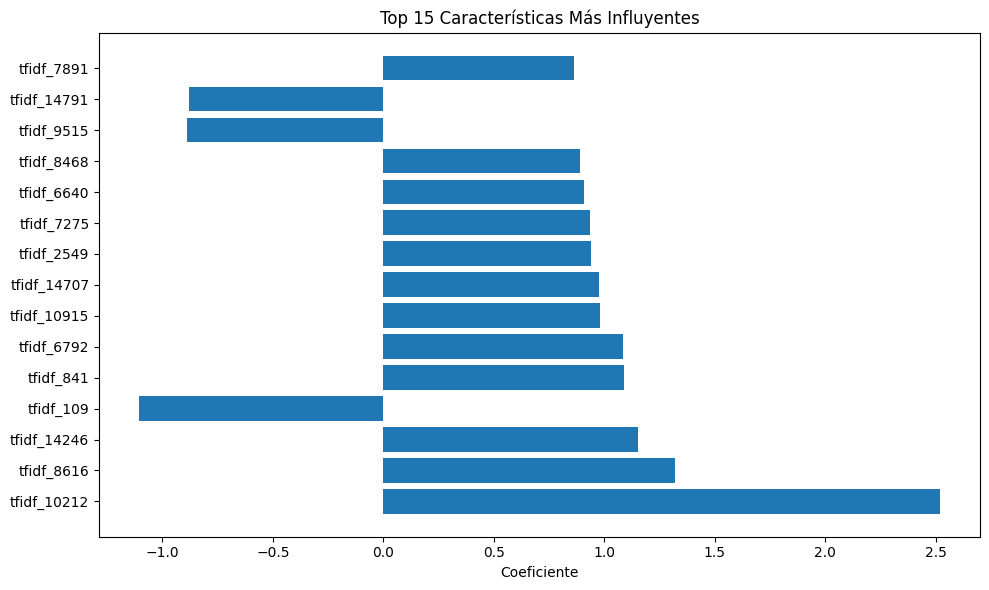

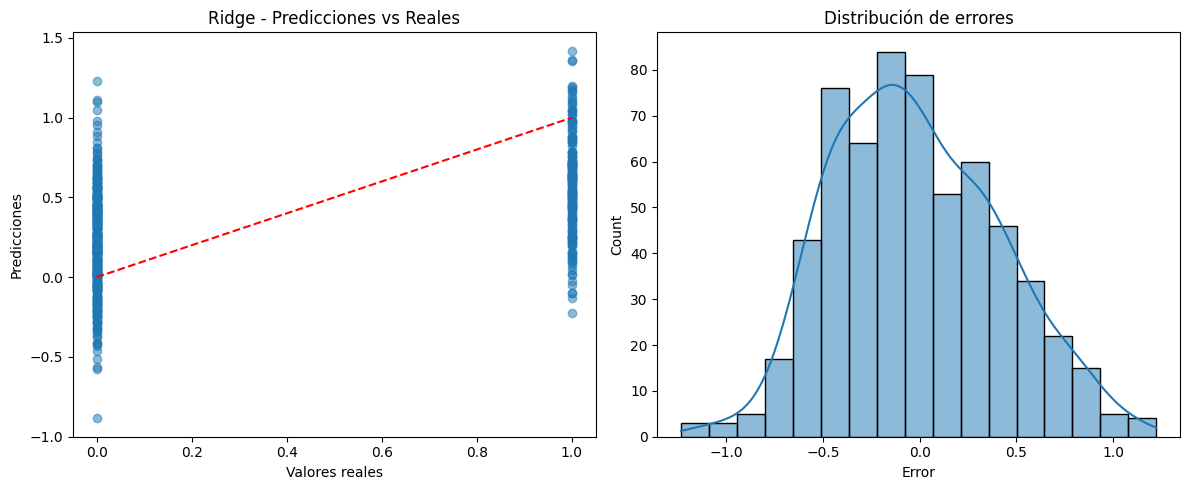

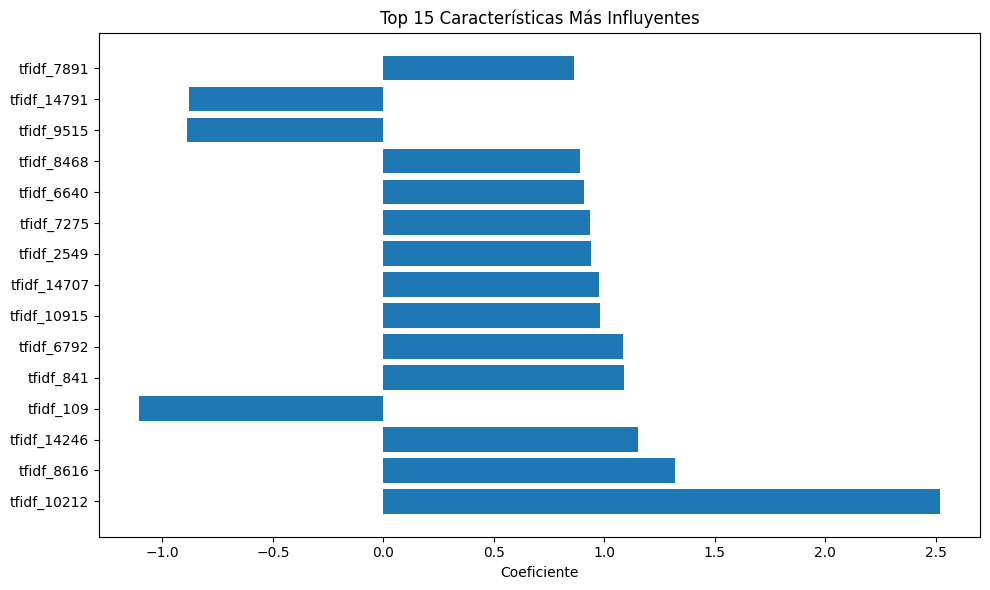

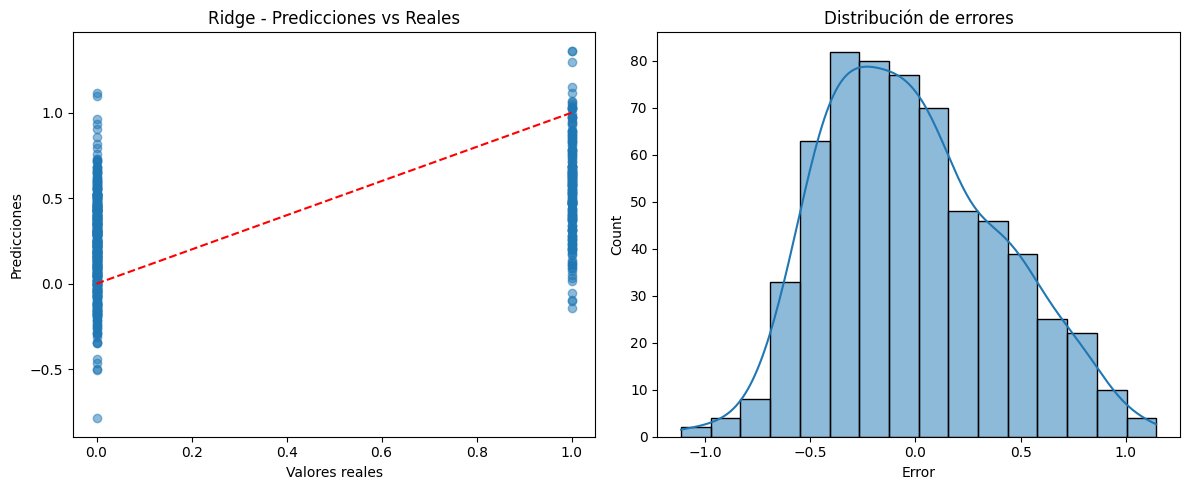

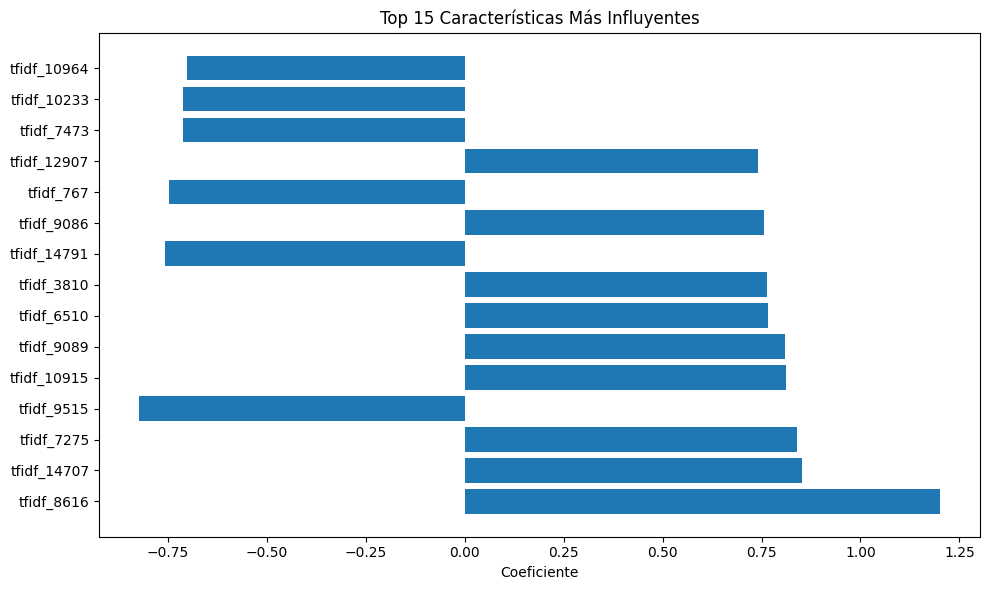

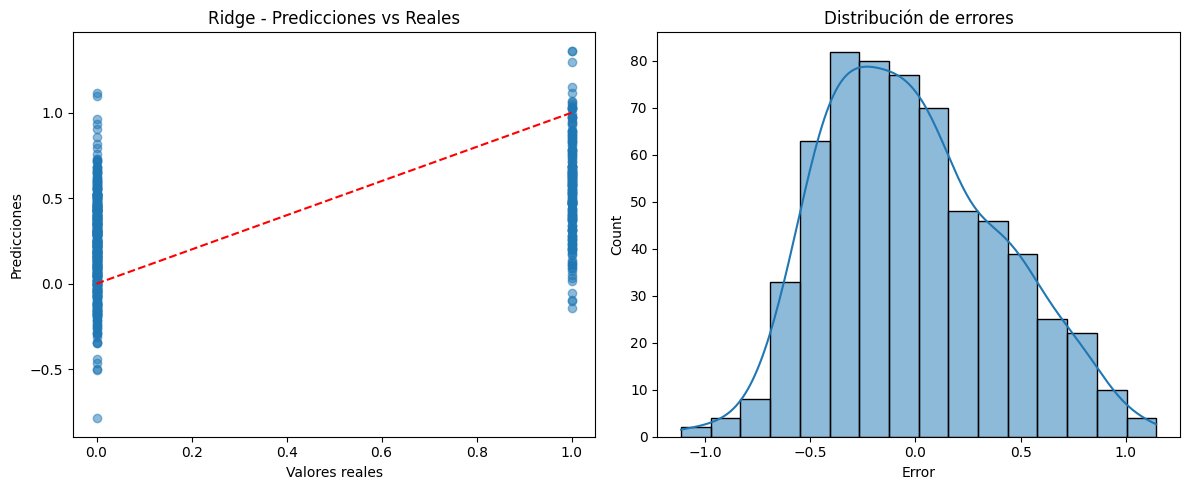

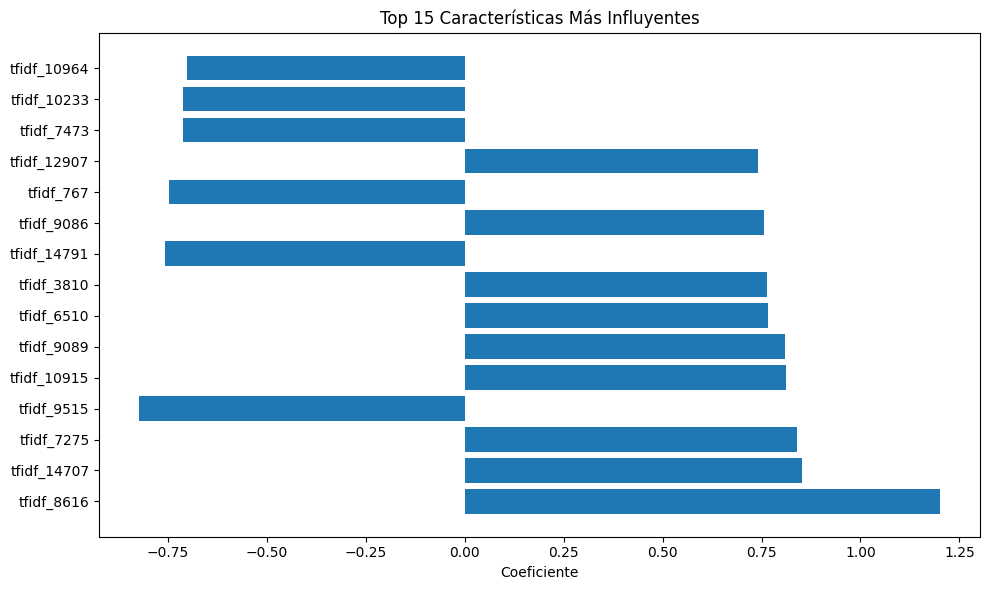

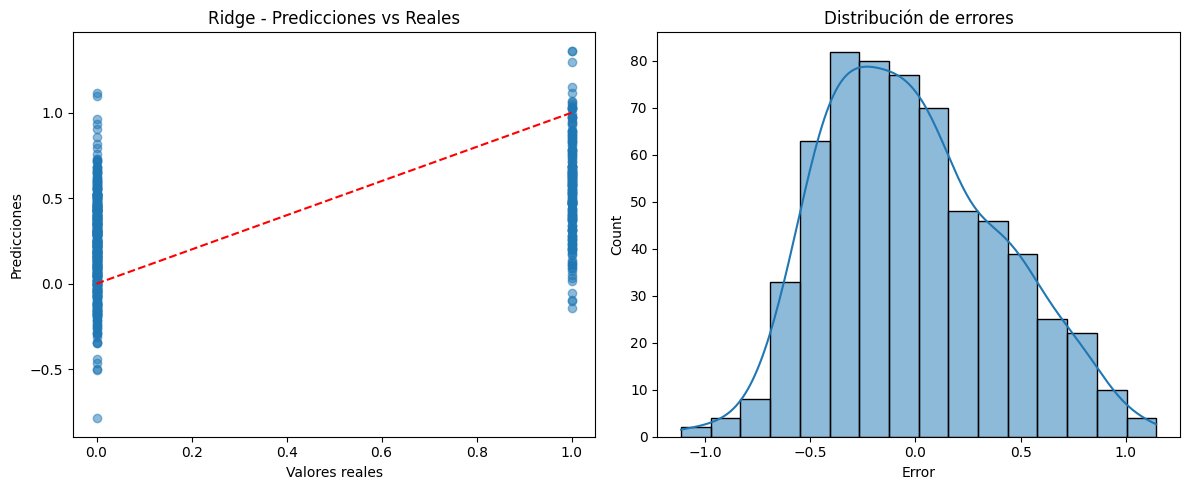

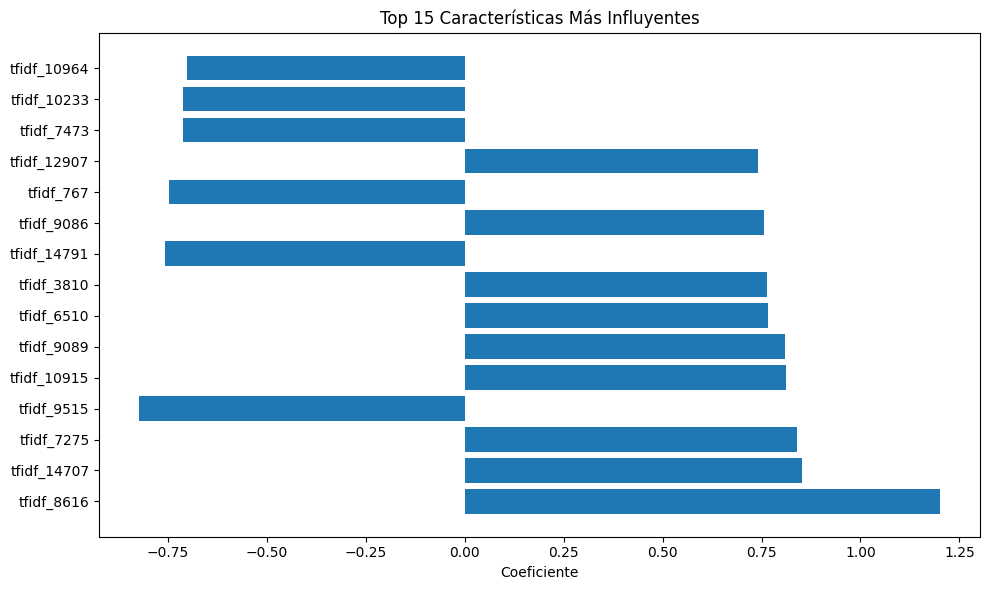

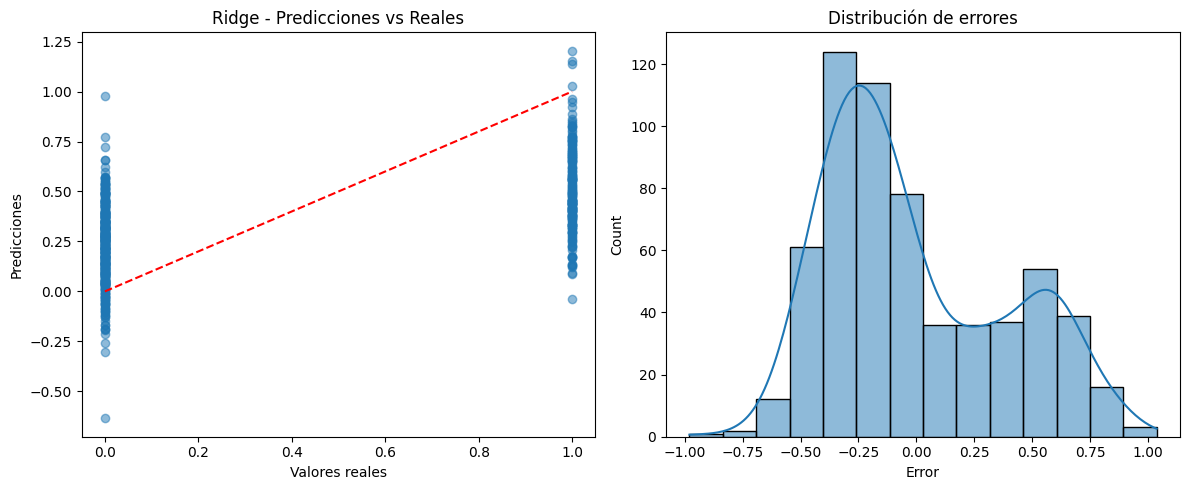

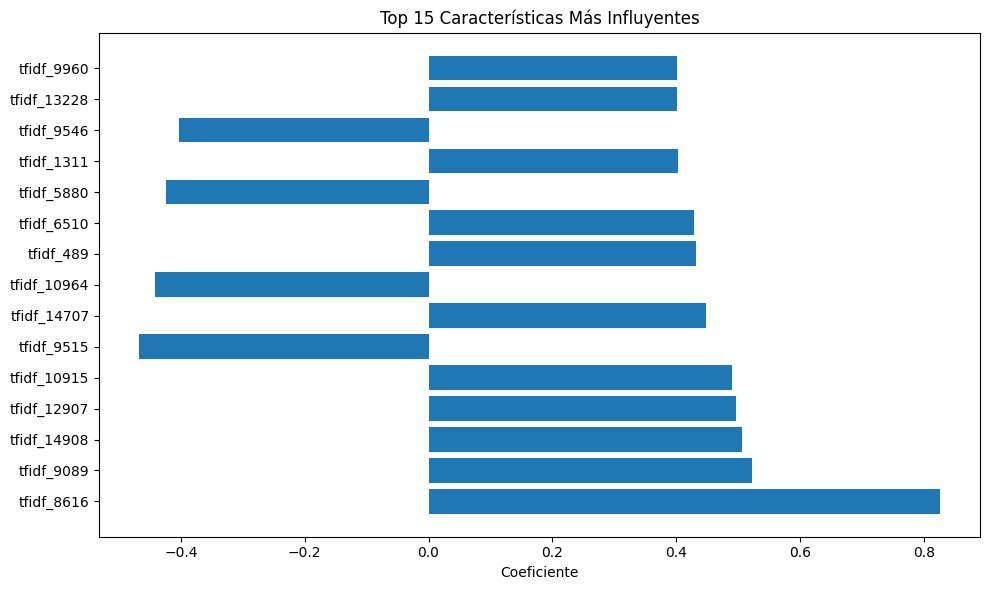

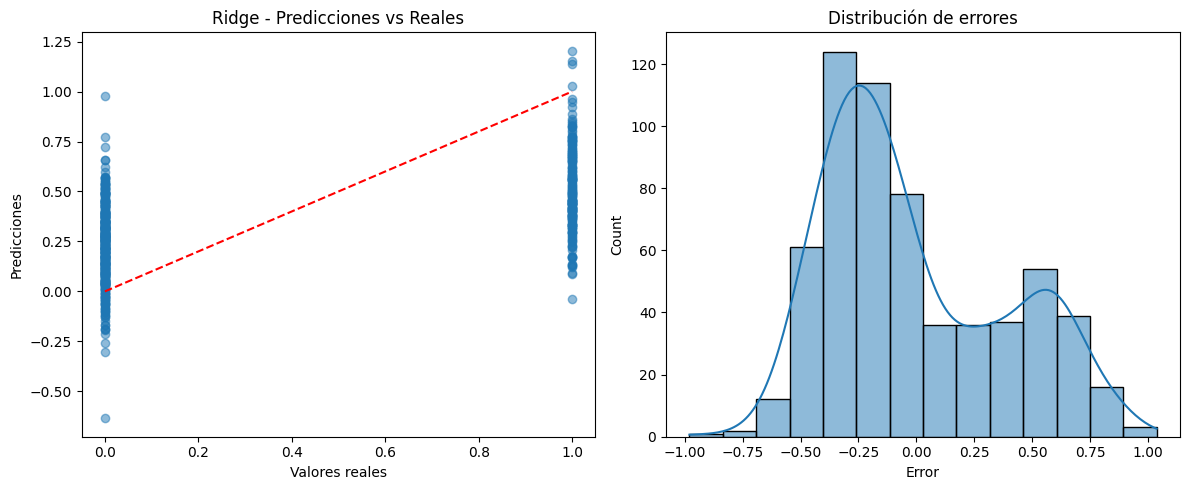

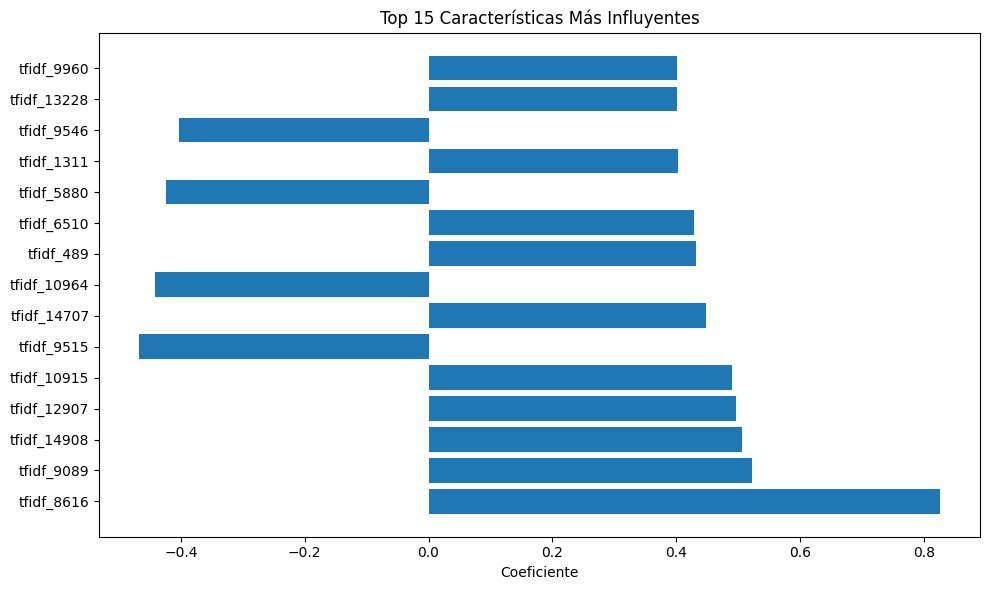

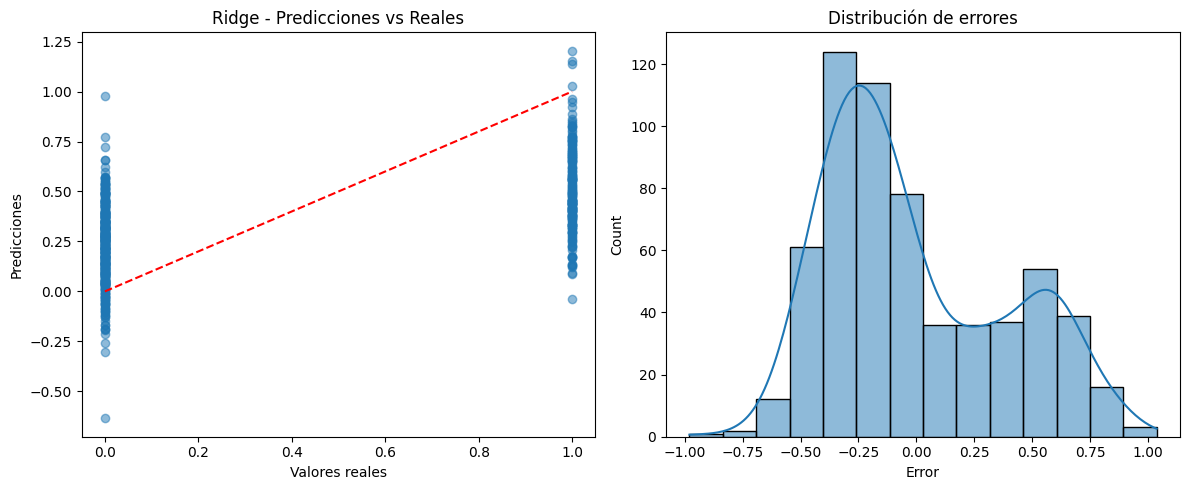

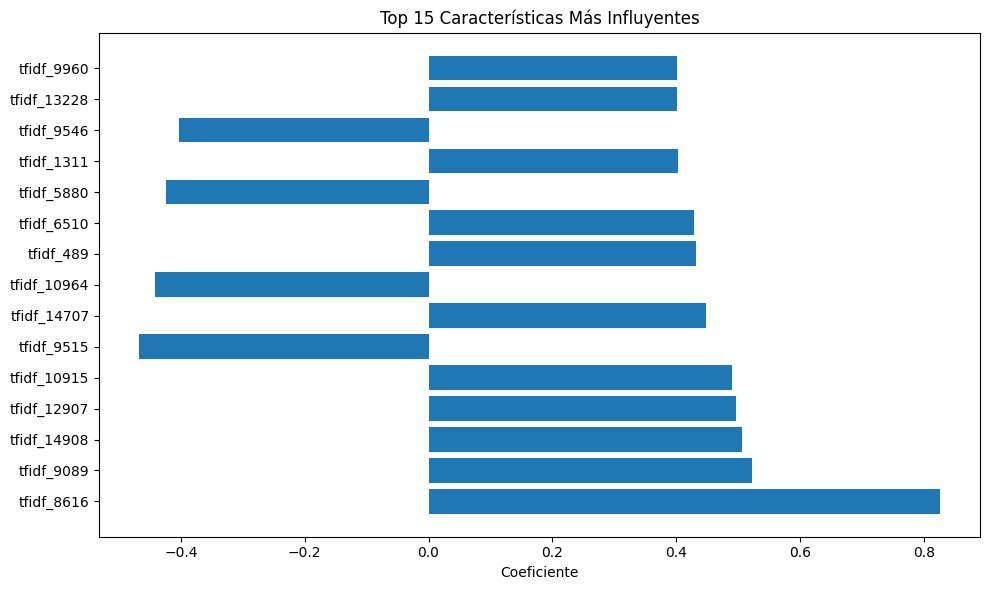

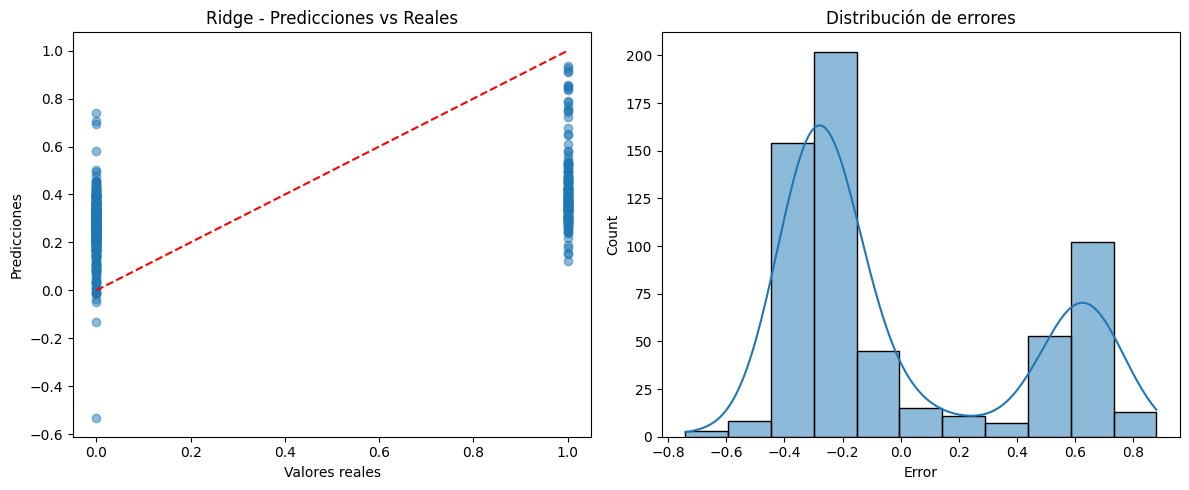

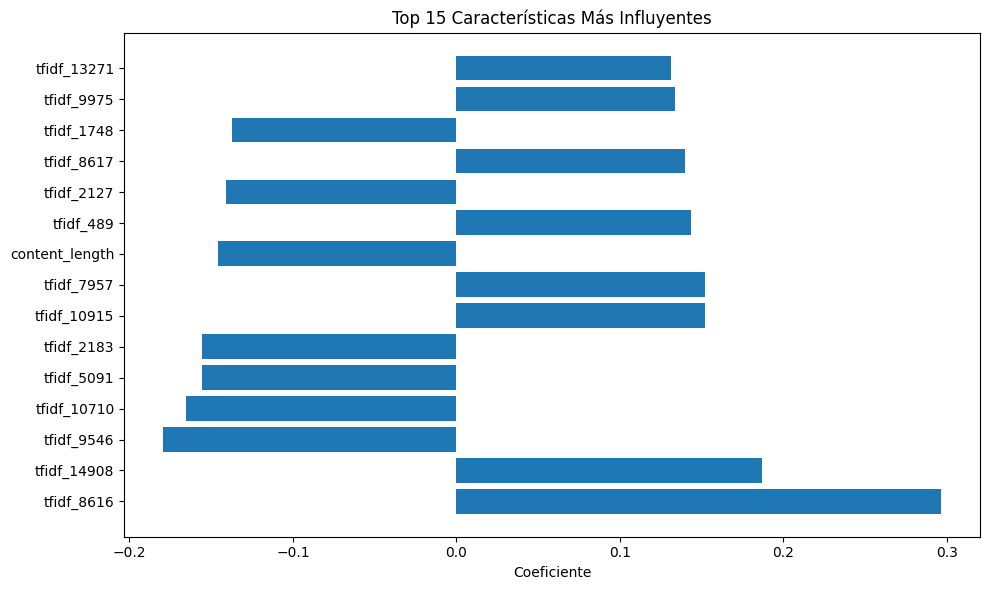

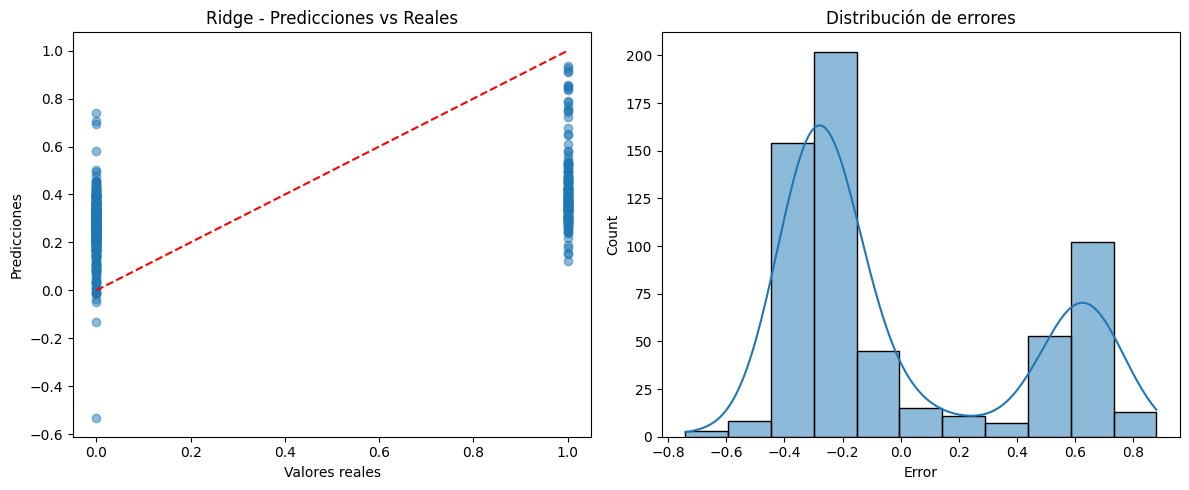

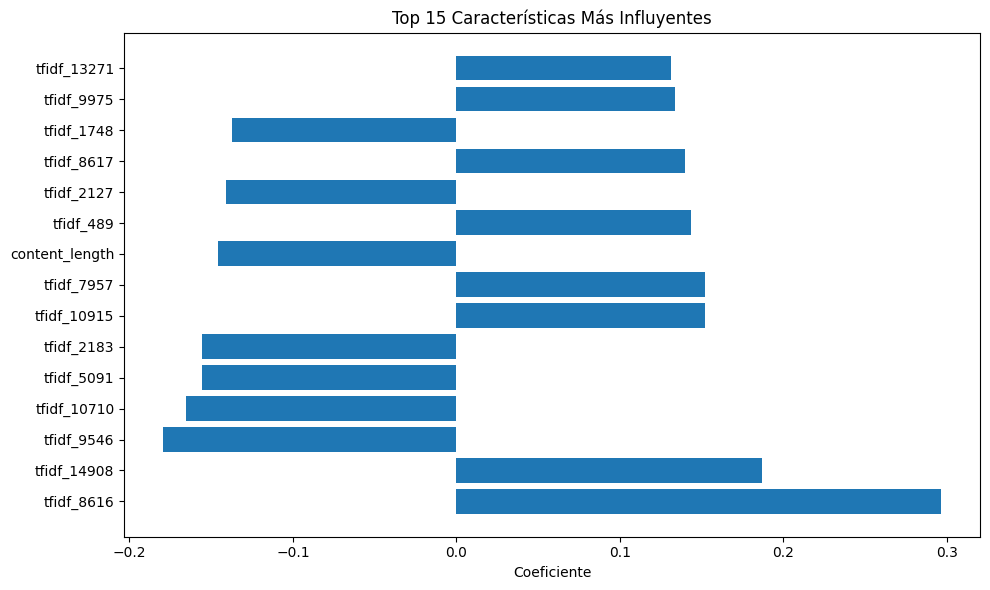

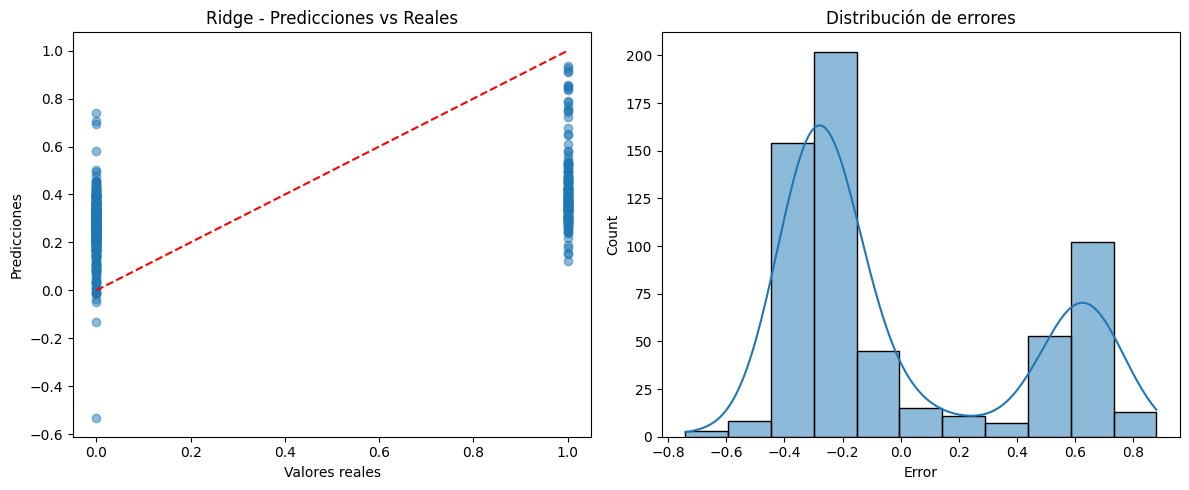

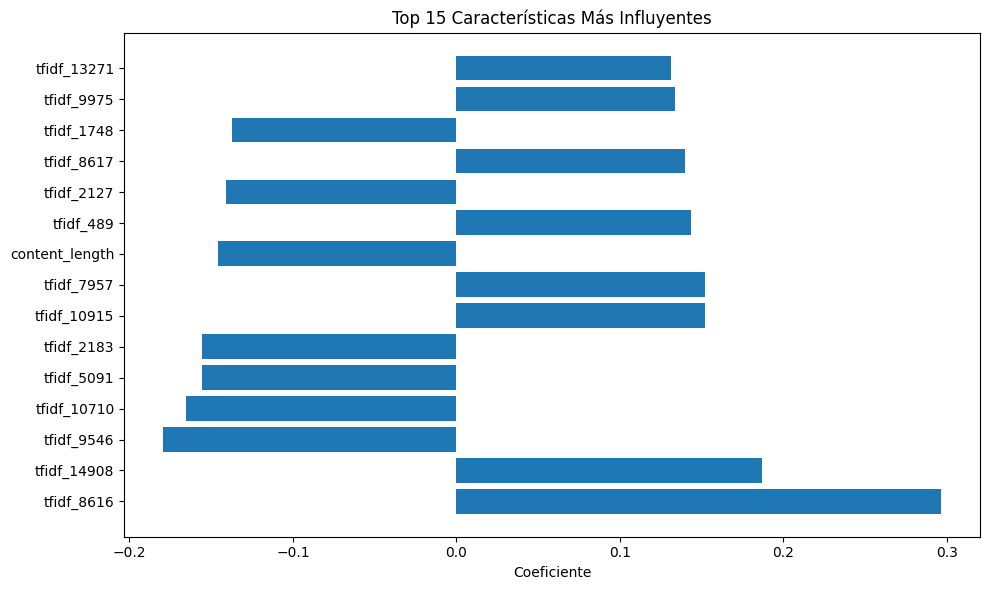

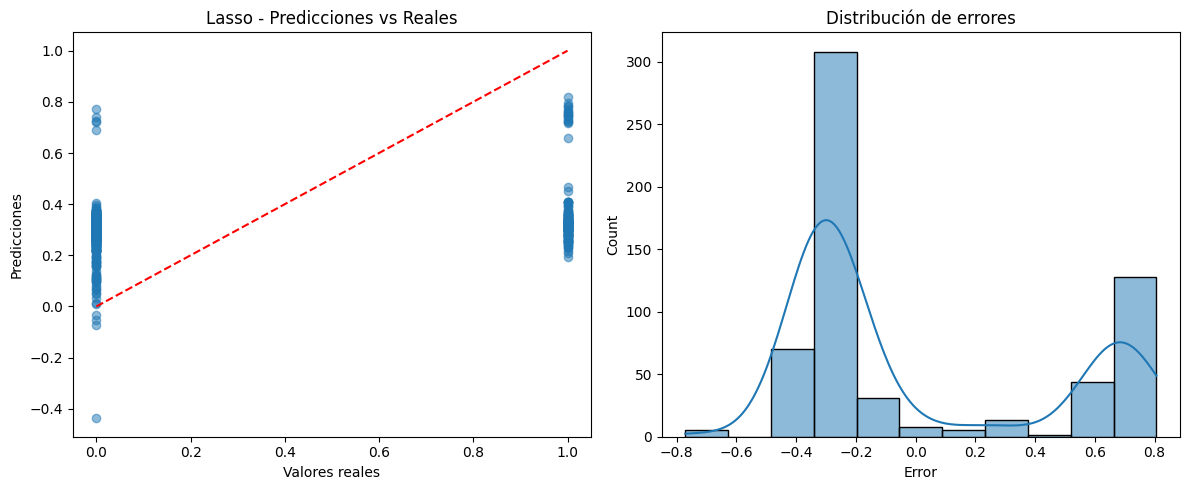

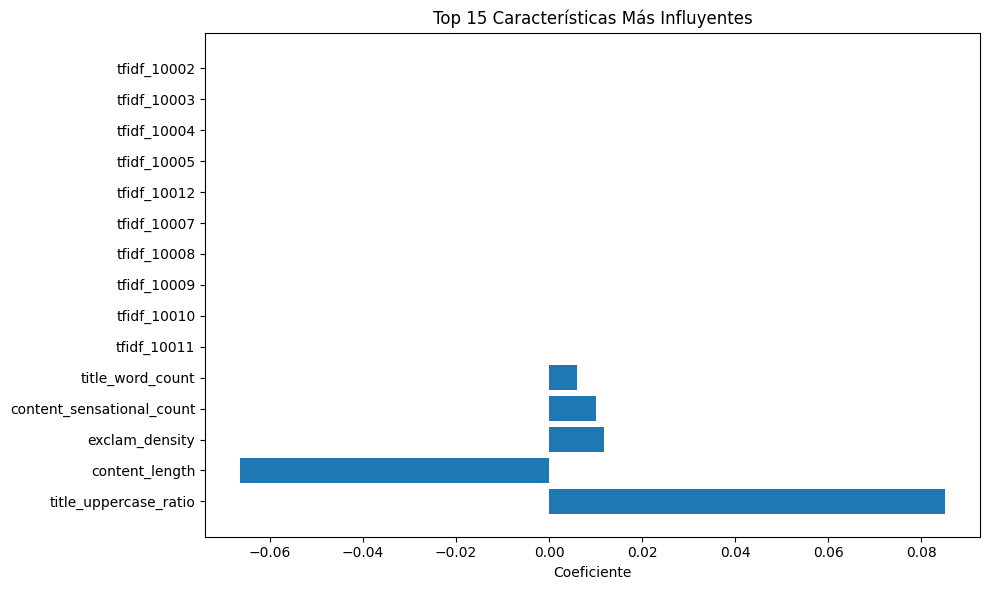

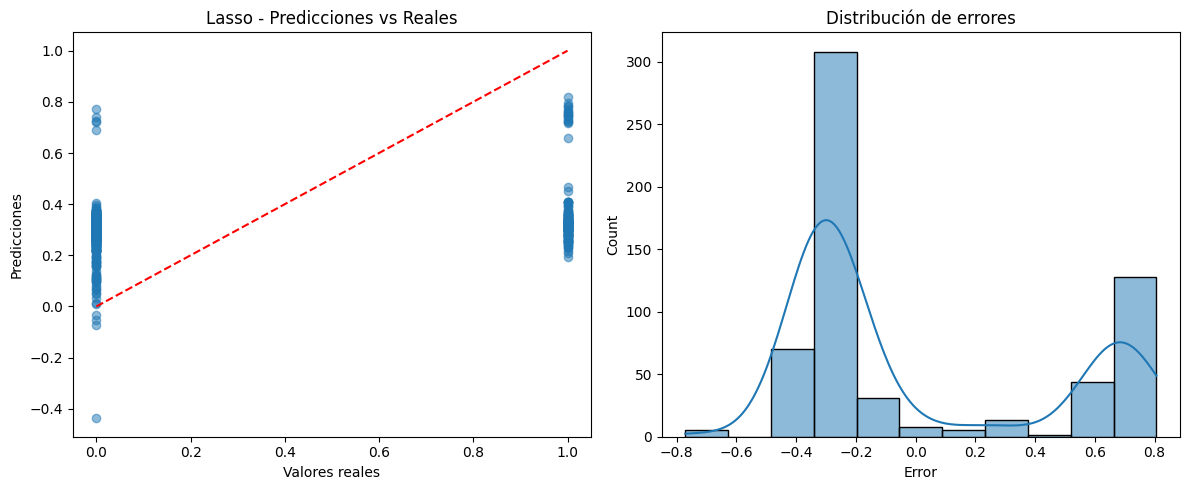

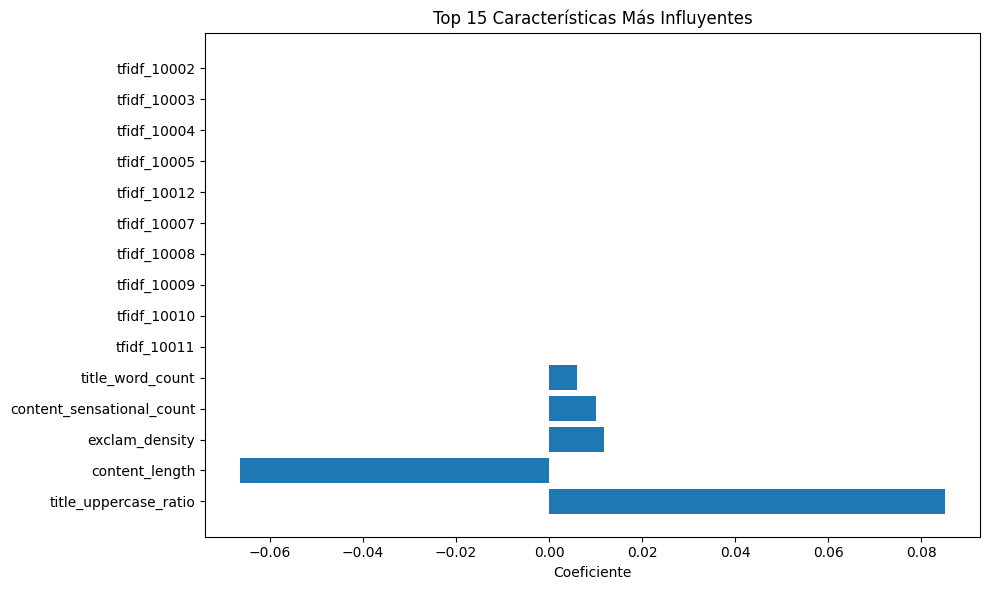

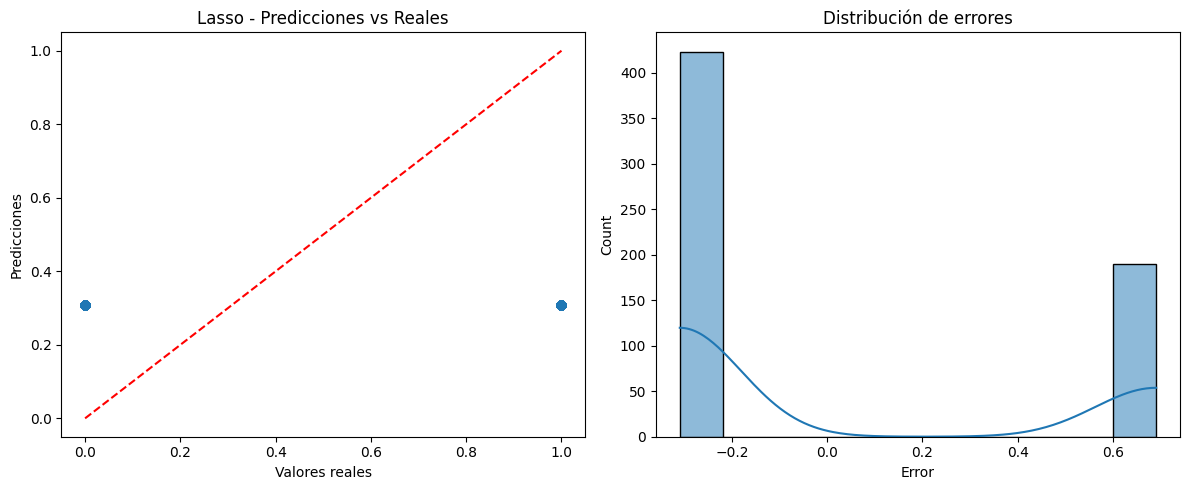

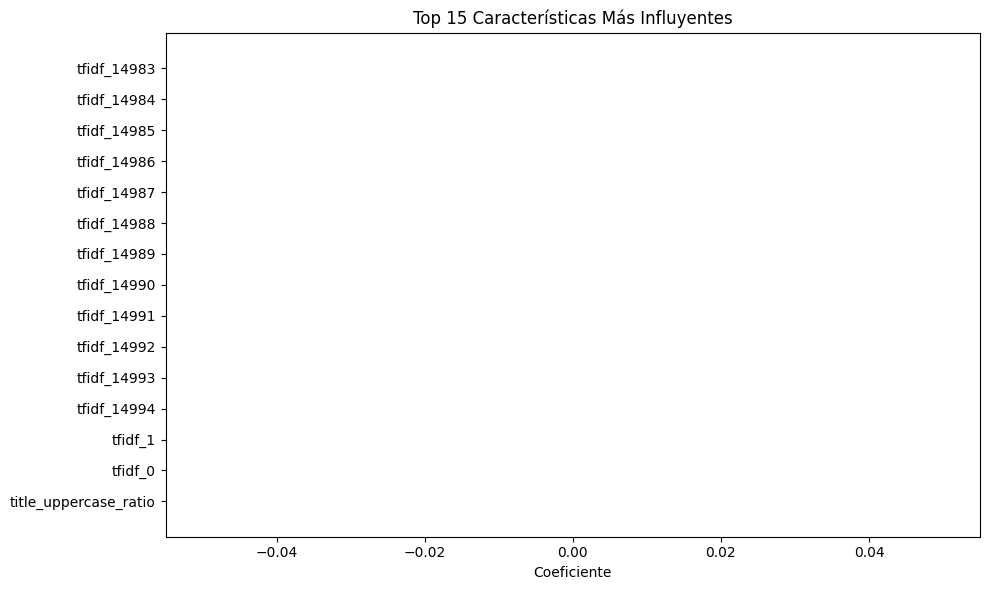

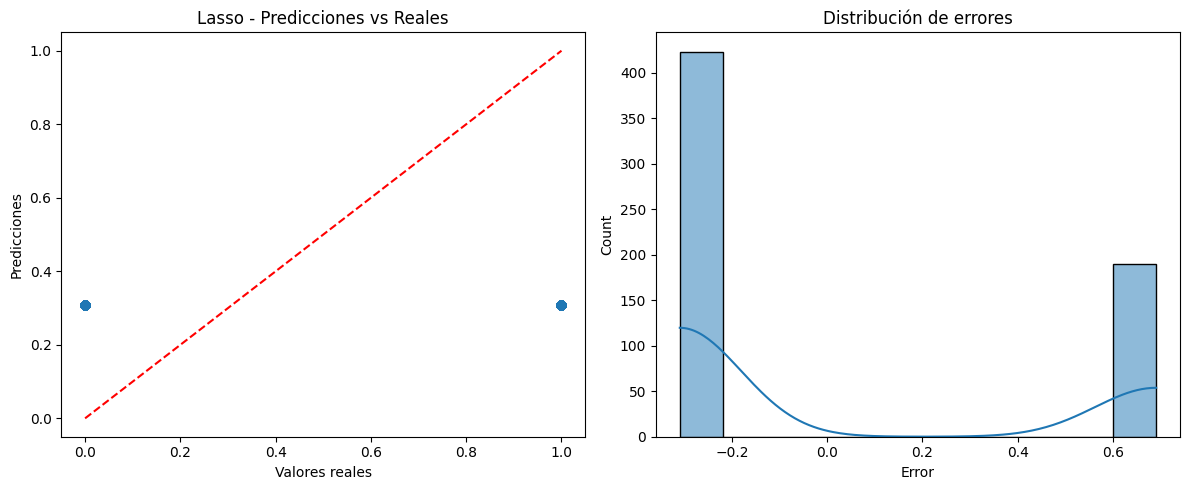

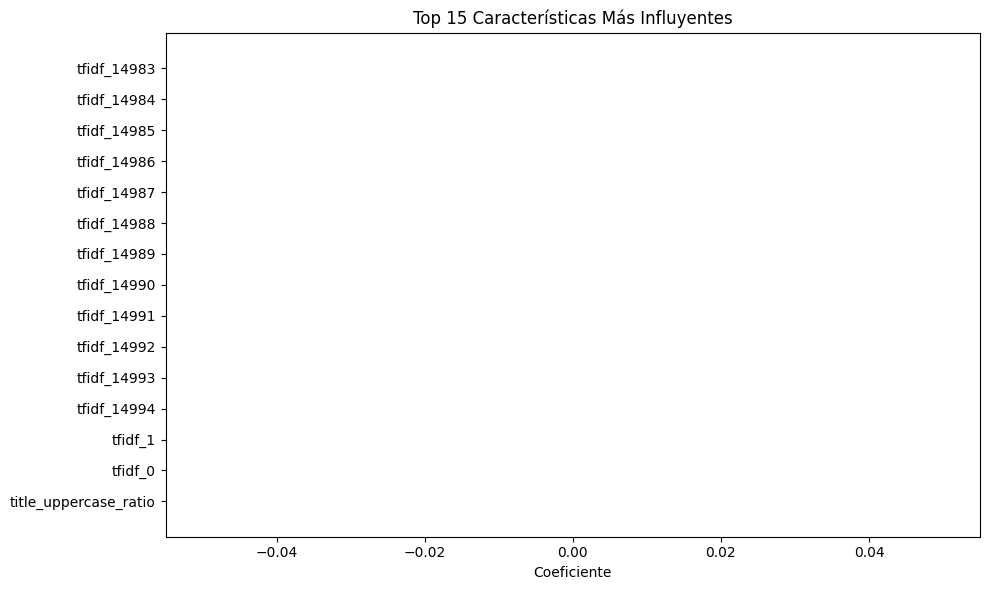

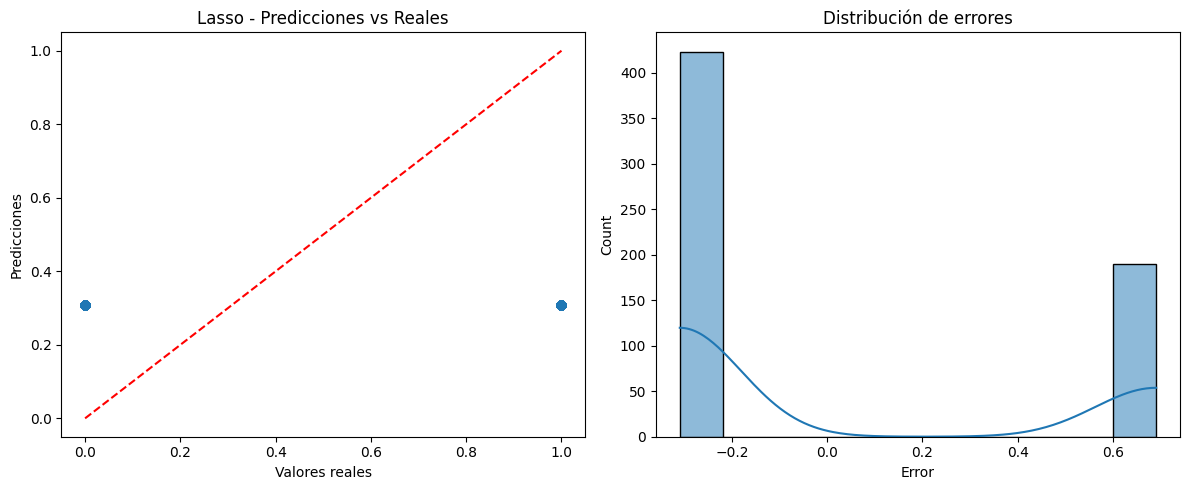

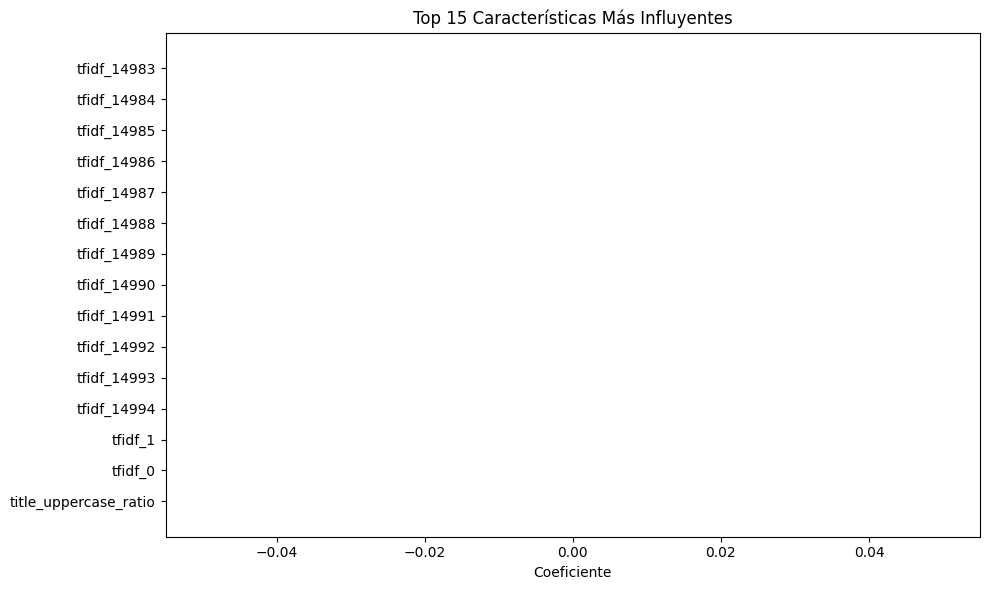

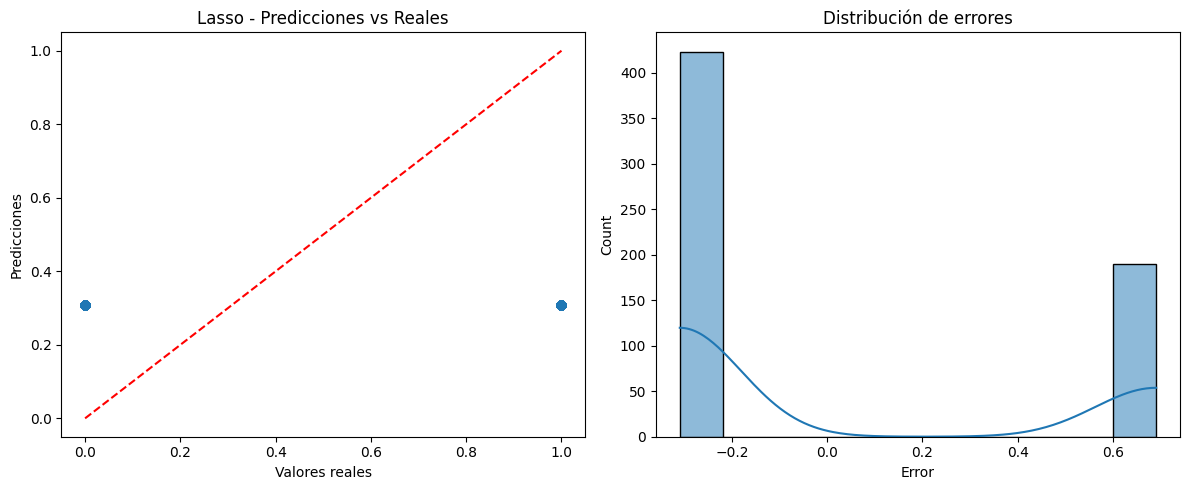

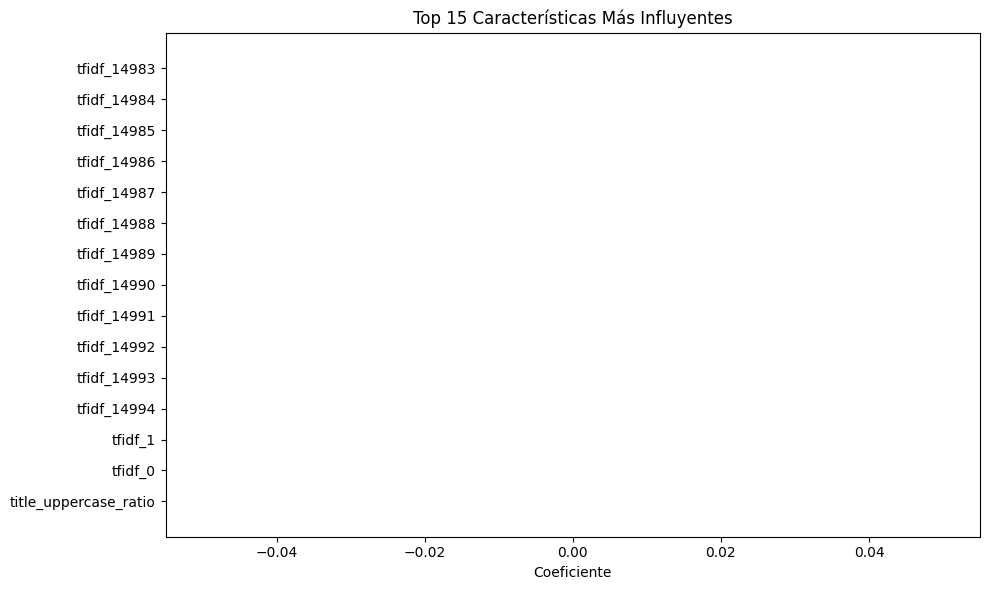

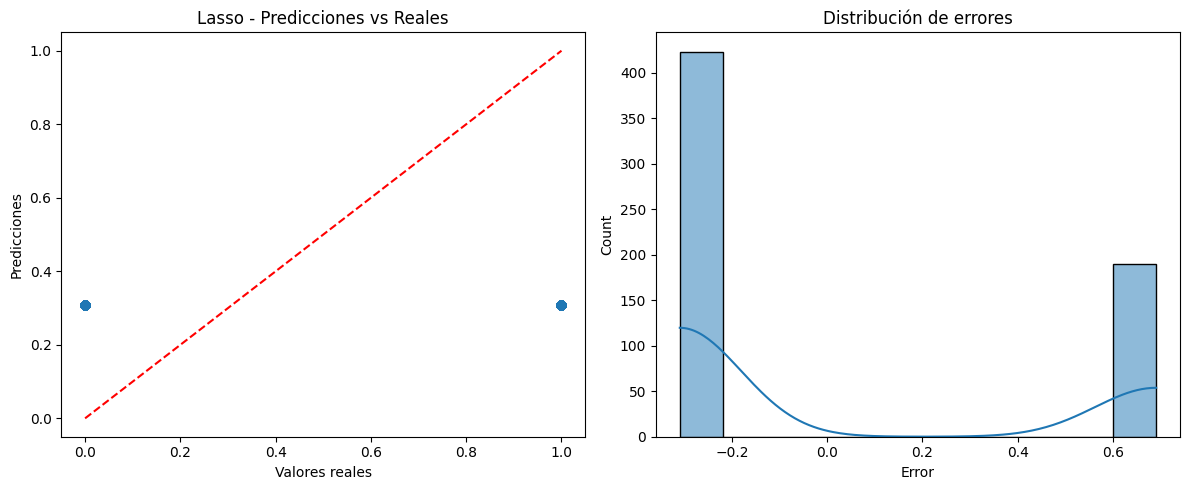

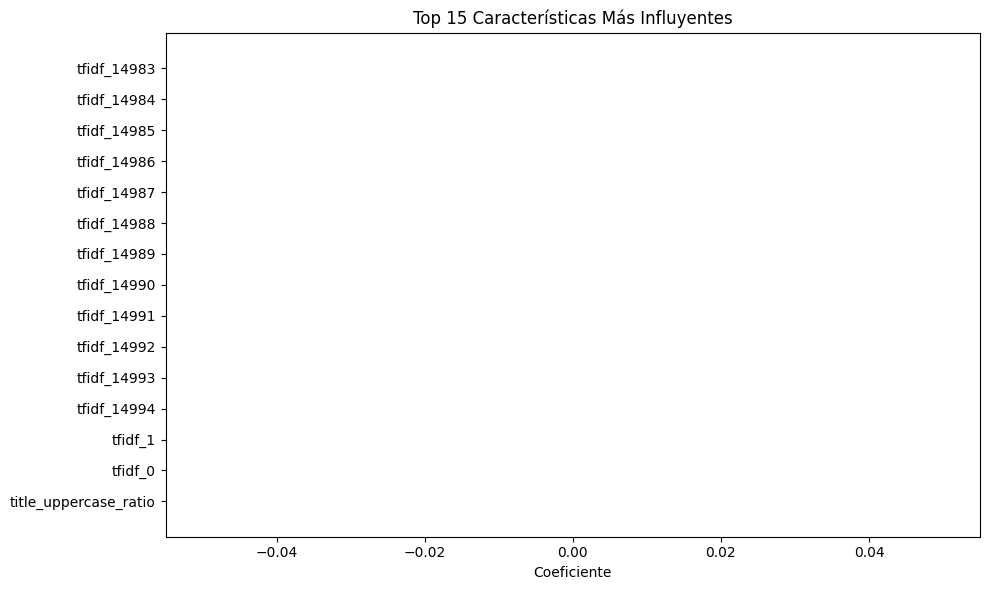

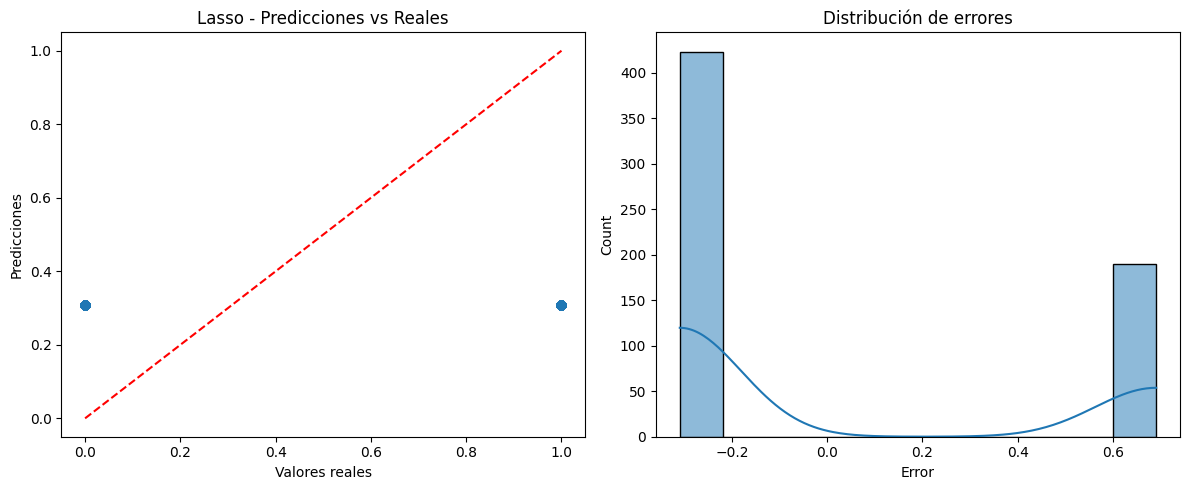

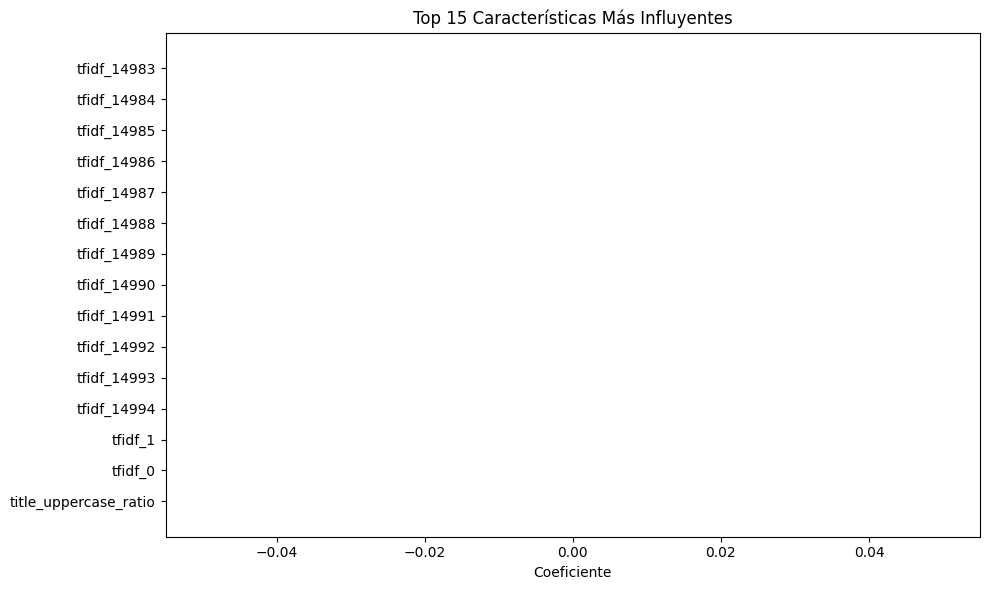

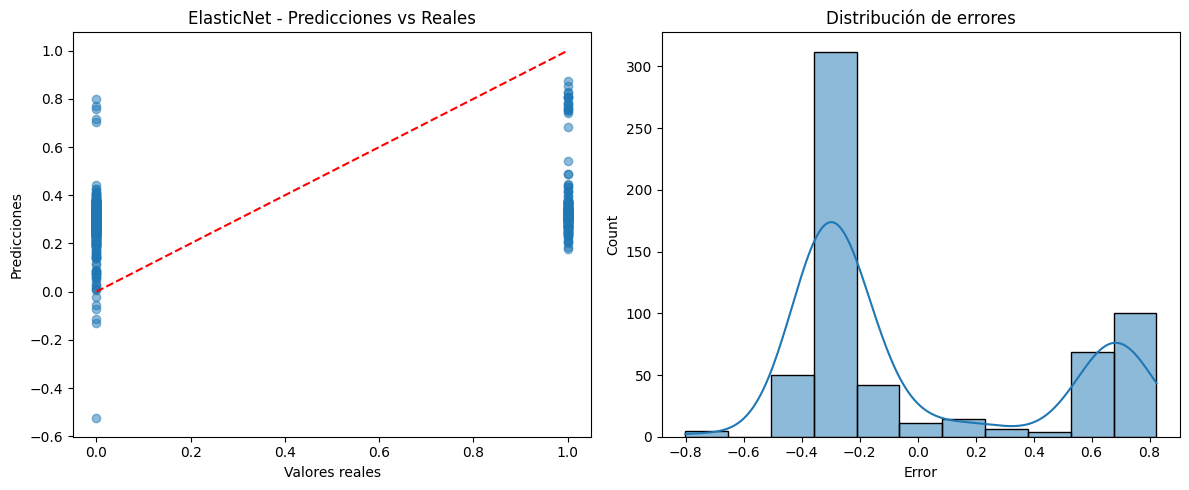

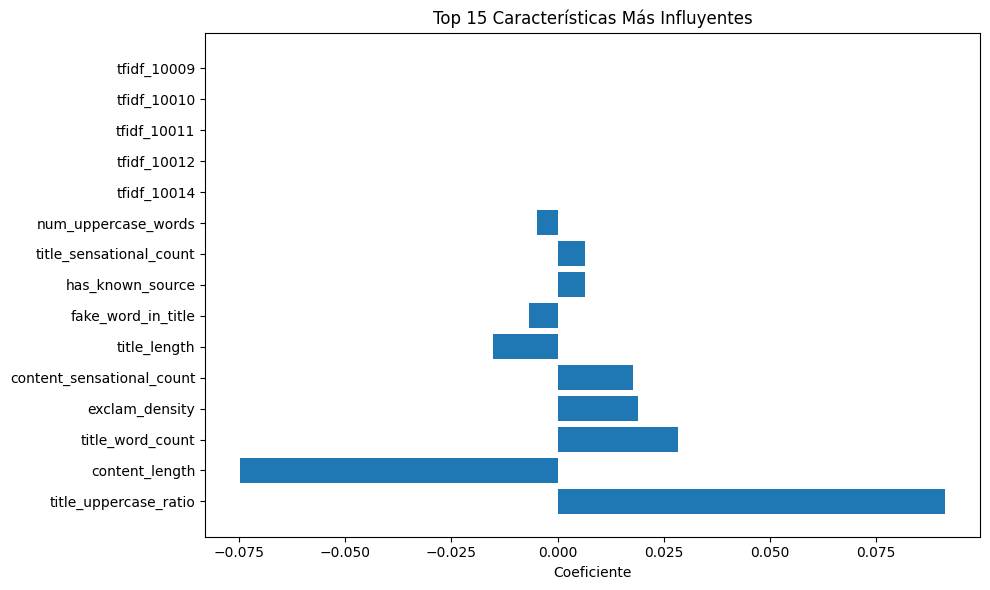

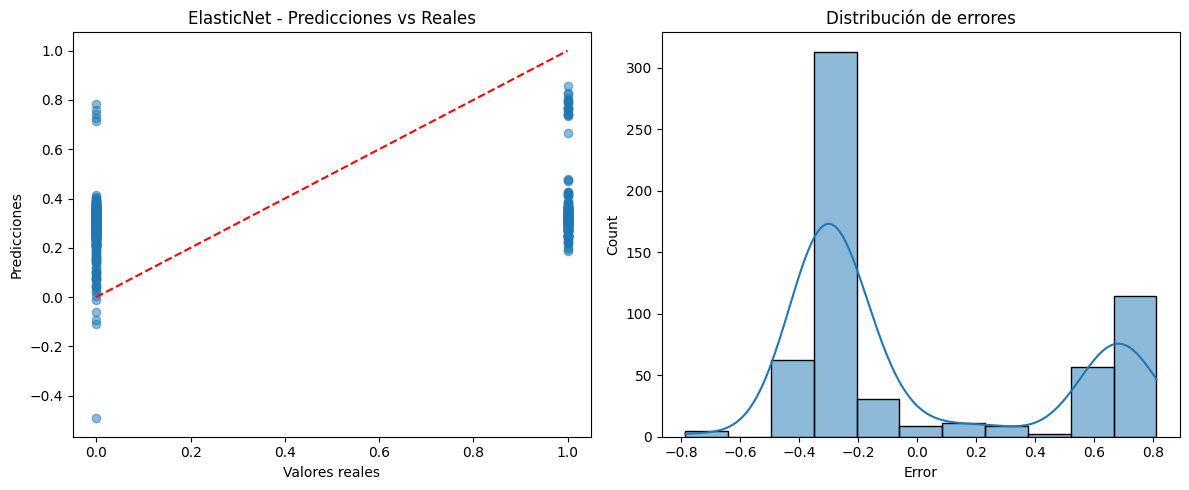

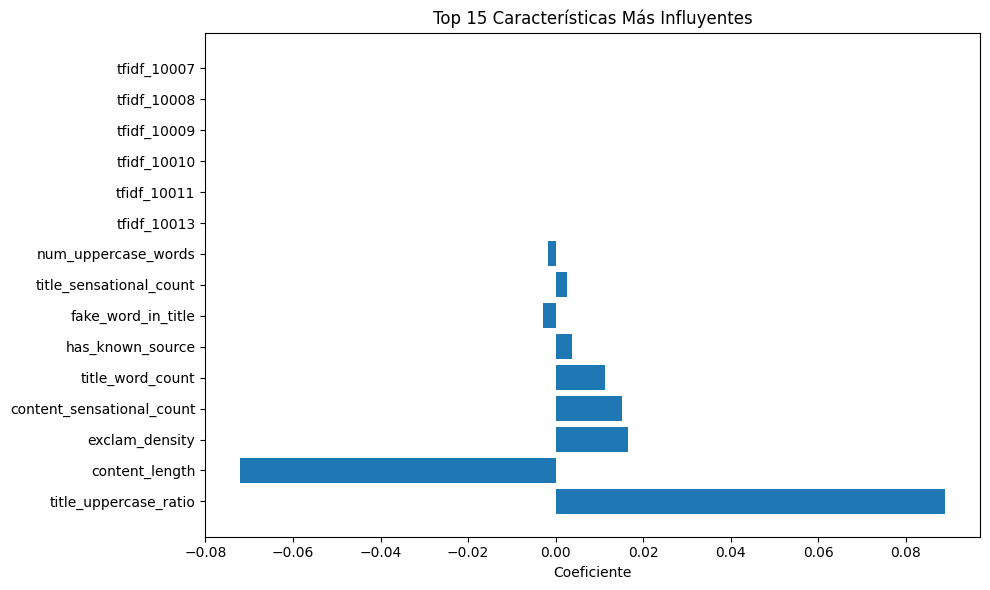

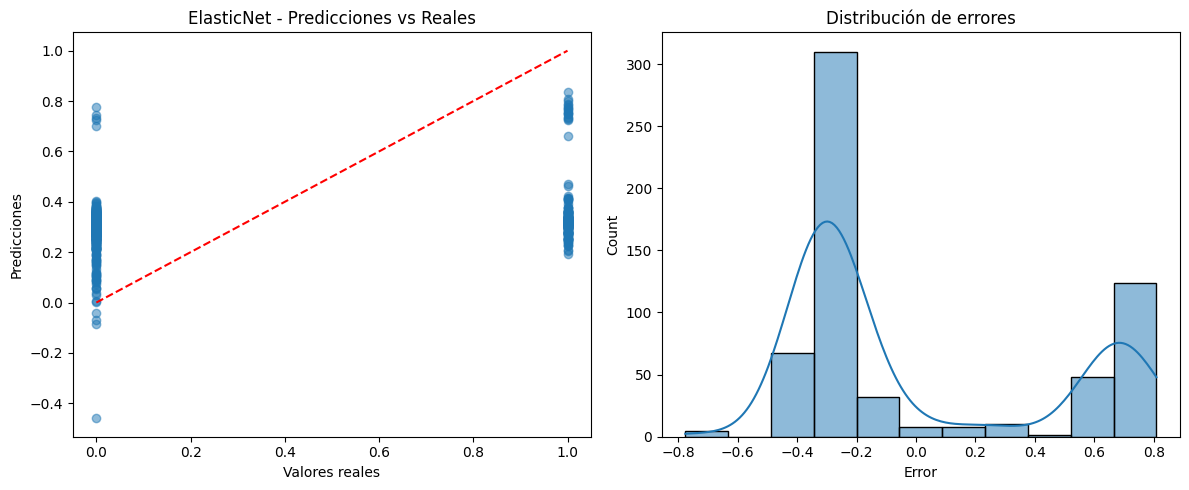

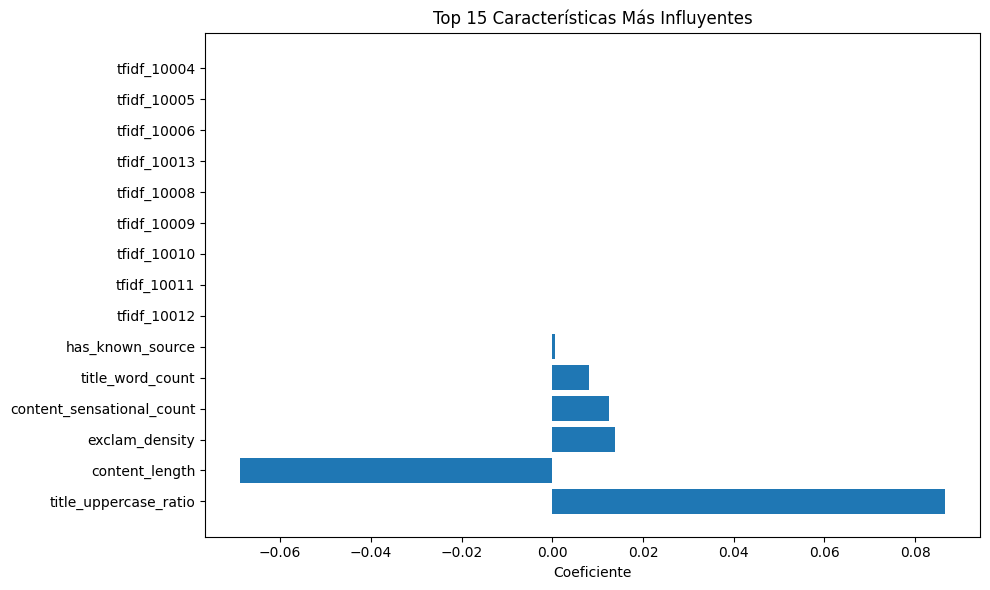

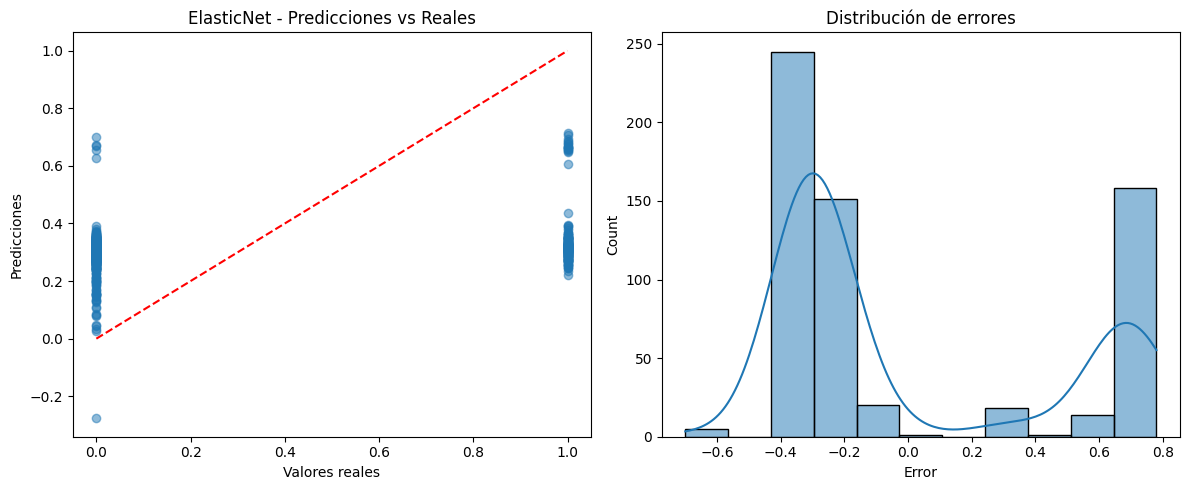

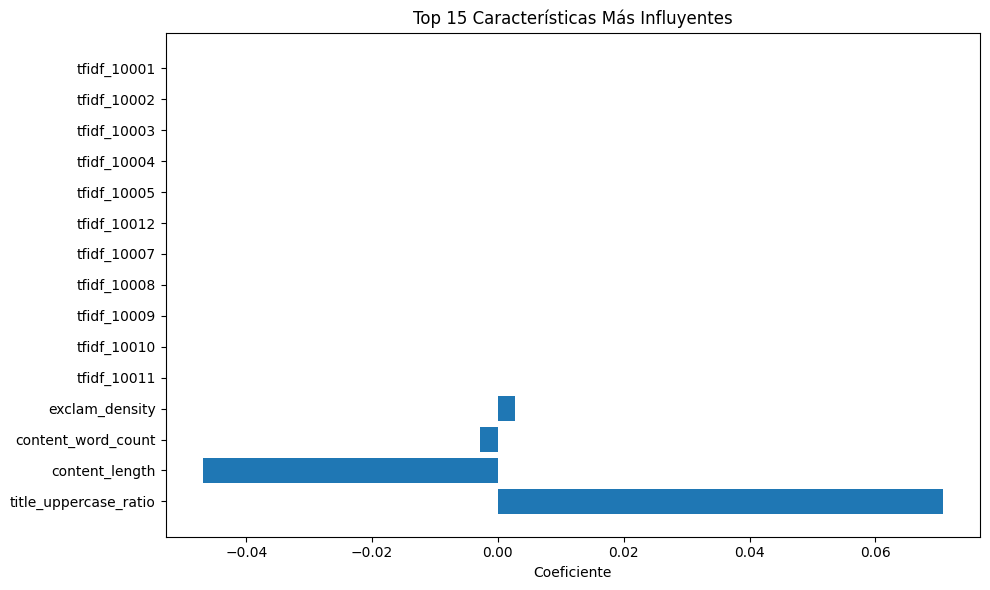

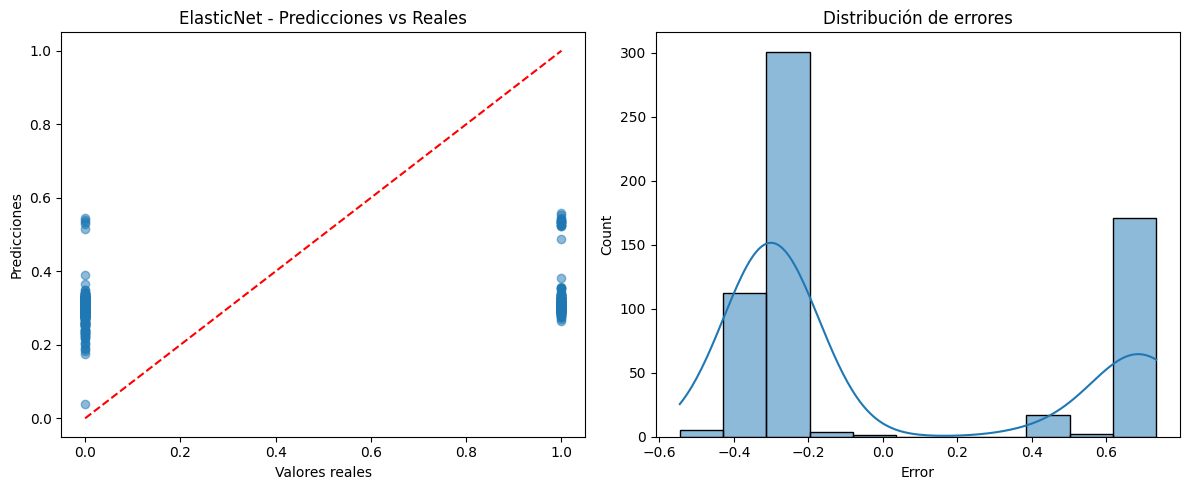

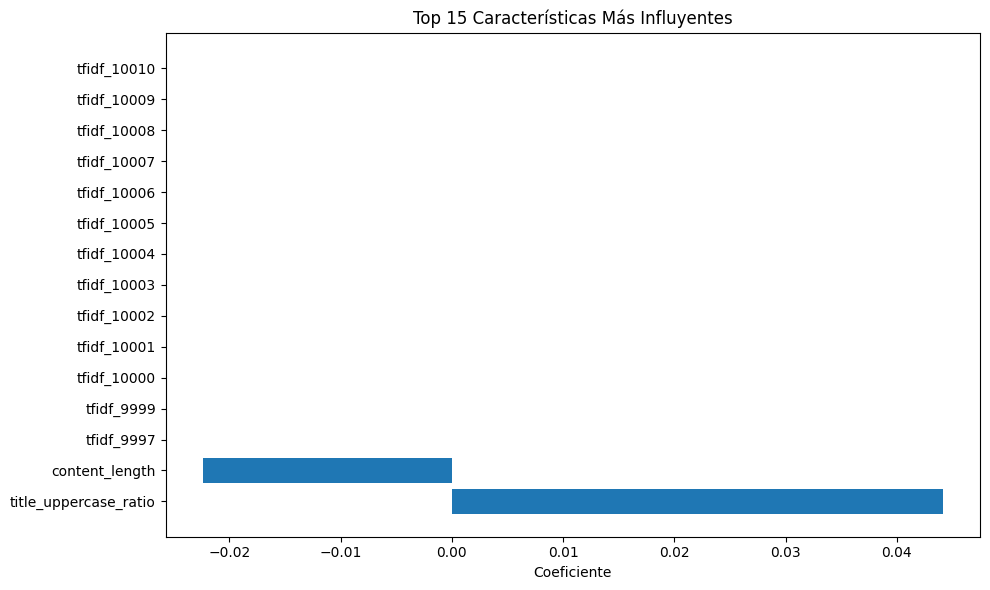

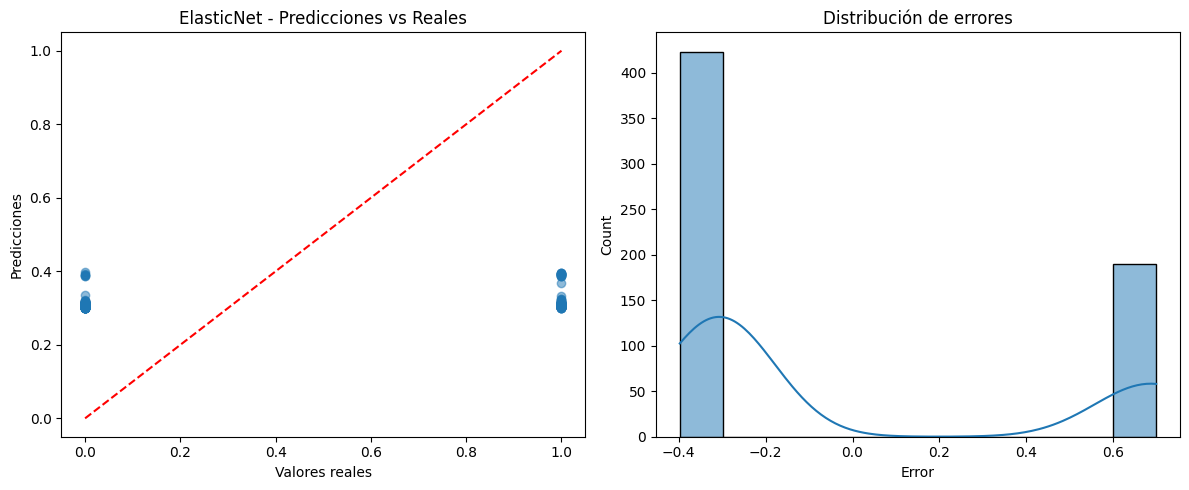

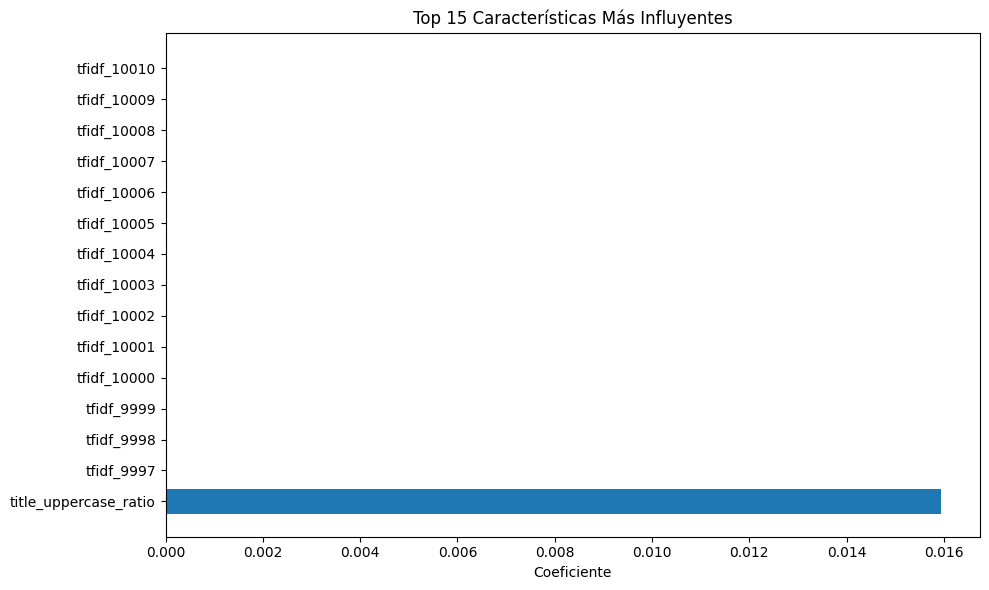

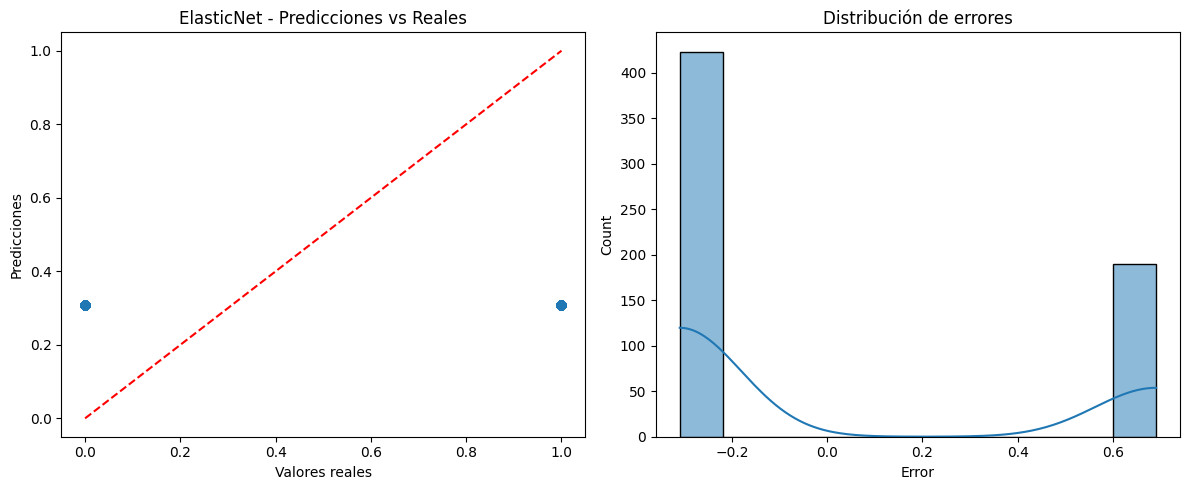

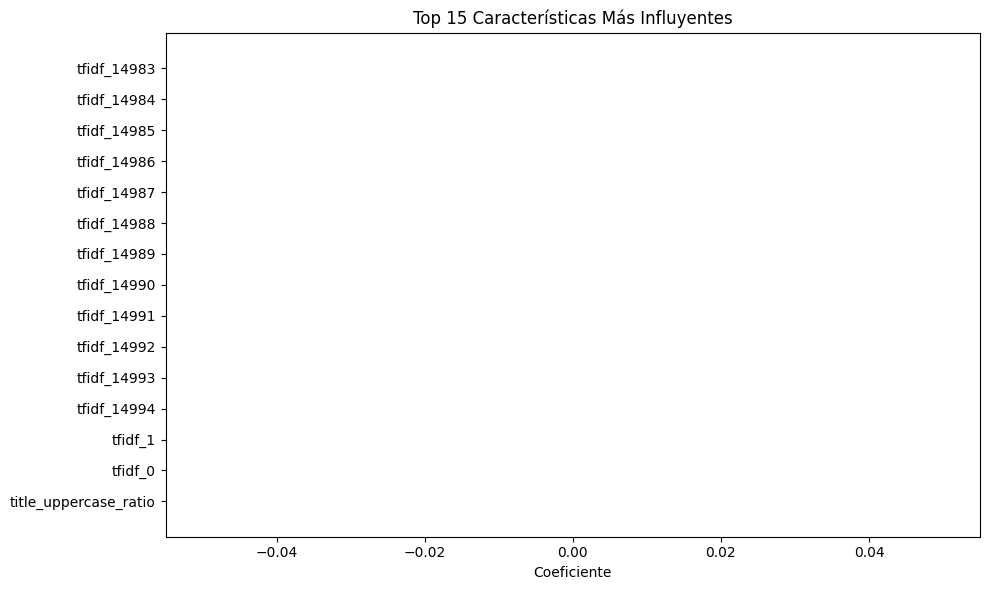

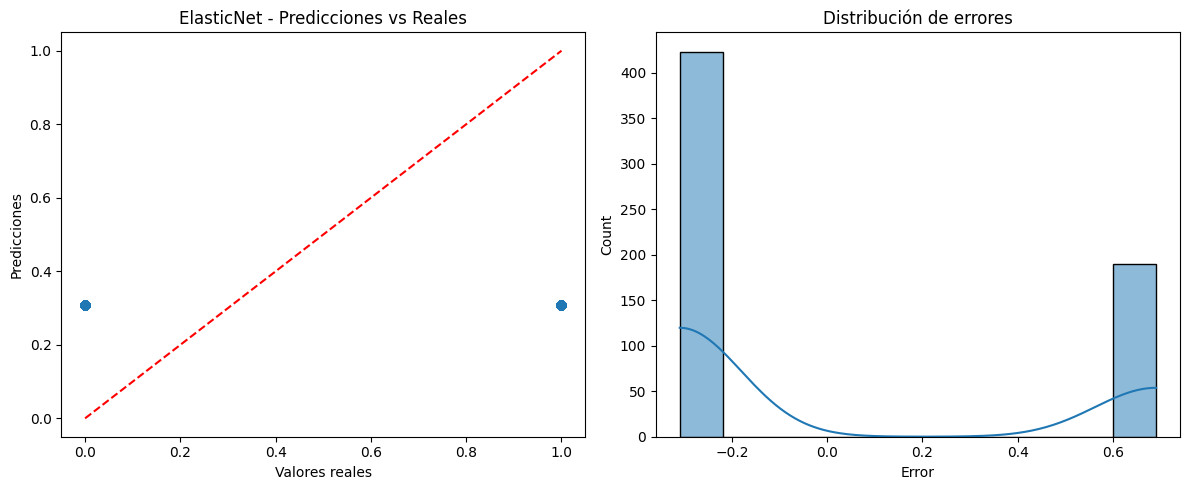

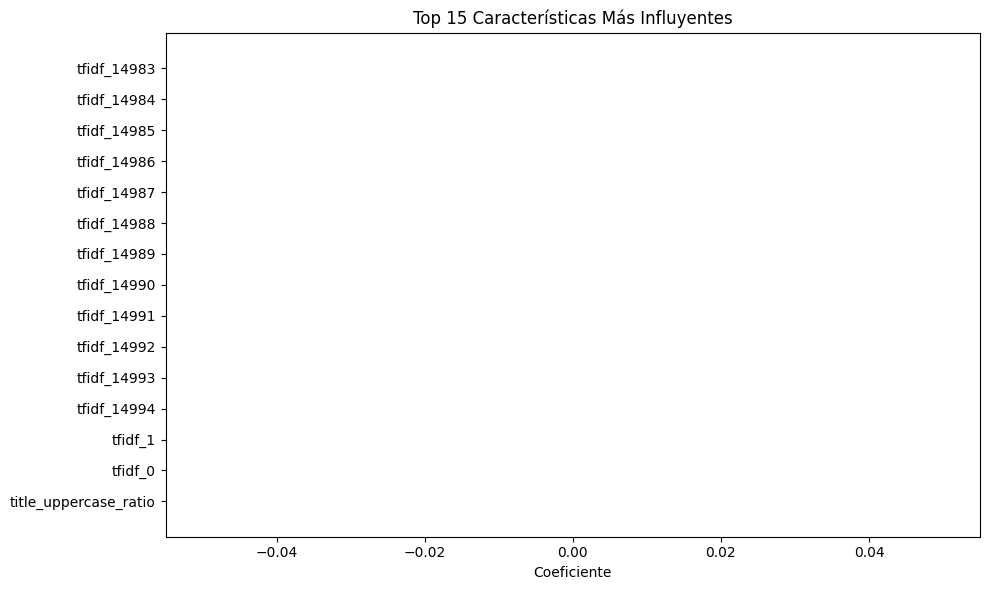

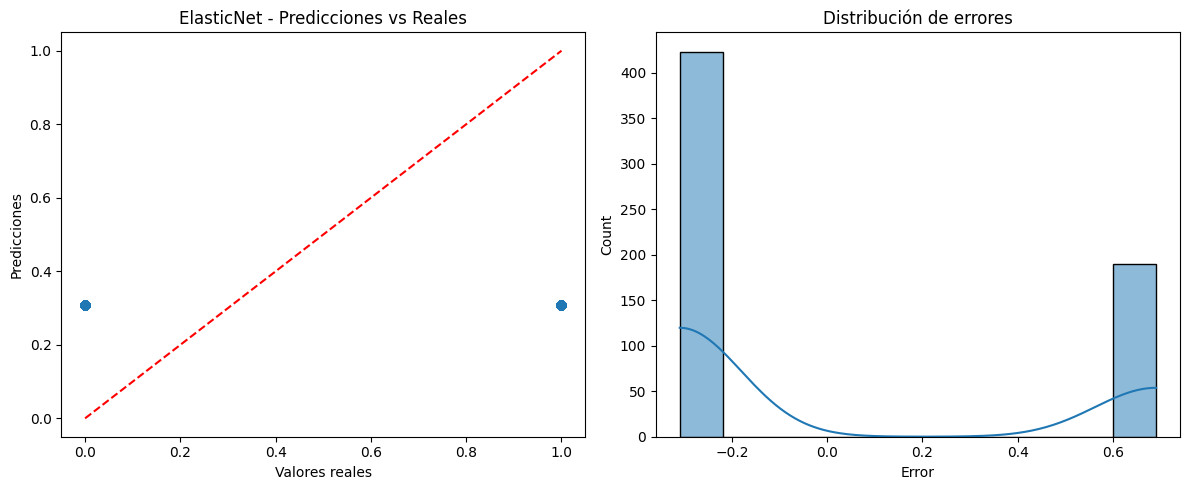

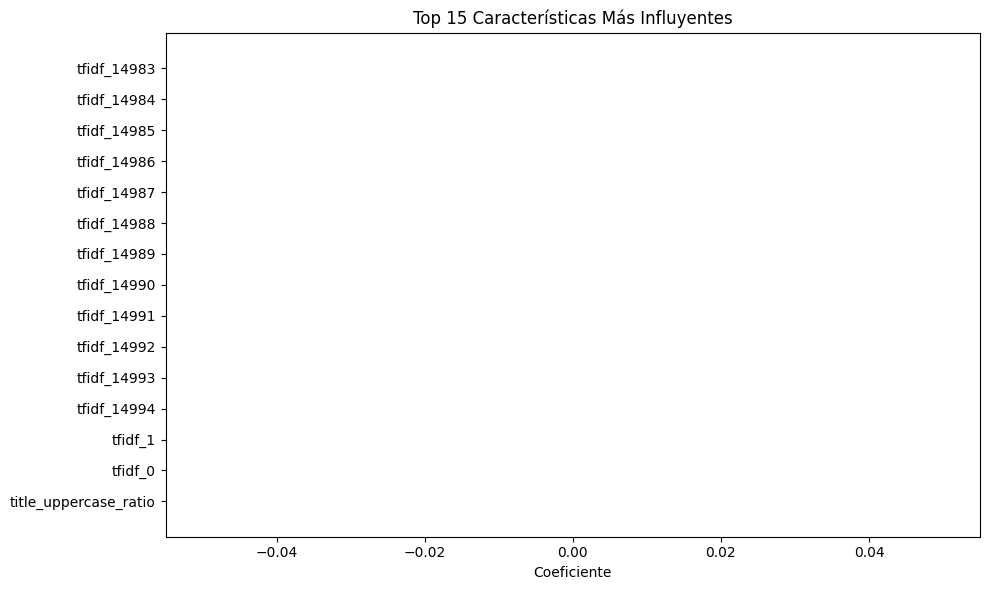

In [14]:
# -------------------- ENTRENAMIENTO Y EVALUACIÓN DEL MODELO --------------------

# Define modelos y sus hiperparámetros
models = {
    'LinearRegression': {
        'model': LinearRegression,
        'params': [{}]
    },
    'Ridge': {
        'model': Ridge,
        'params': ParameterGrid({
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'solver': ['auto', 'svd', 'cholesky']
        })
    },
    'Lasso': {
        'model': Lasso,
        'params': ParameterGrid({
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'max_iter': [1000, 3000]
        })
    },
    'ElasticNet': {
        'model': ElasticNet,
        'params': ParameterGrid({
            'alpha': [0.01, 0.1, 1.0],
            'l1_ratio': [0.2, 0.5, 0.8],
            'max_iter': [1000]
        })
    }
}

# Configura experimento en MLflow
experiment_name = "Regresión Noticias Falsas"
mlflow.set_experiment(experiment_name)
print(f"Experimento configurado: {experiment_name}")

# Variables para rastrear mejor modelo
best_model = None
best_score = float('-inf')
best_params = None
best_model_name = None

total_combinations = sum(len(list(info['params'])) for info in models.values())
current_combo = 0

print(f"Total de modelos a probar: {total_combinations}")

with mlflow.start_run(run_name="Modelos Lineales V2") as parent_run:
    mlflow.set_tags({
        "modelo": "Regresión Lineal y Variantes",
        "preprocesamiento": "TF-IDF + Escalado selectivo",
        "experimentador": "AngelBReal"
    })

    # Recorre modelos
    for model_name, model_info in models.items():
        print(f"\n=== Probando modelo: {model_name} ===")
        for params in model_info['params']:
            current_combo += 1
            print(f"\nCombinación {current_combo}/{total_combinations}: {params}")

            model = model_info['model'](**params) if params else model_info['model']()
            run_name = f"{model_name} - {params}" if params else model_name

            with mlflow.start_run(run_name=run_name, nested=True) as child_run:
                try:
                    # Usa datos escalados solo si el modelo lo requiere
                    if model_name == 'LinearRegression':
                        X_train_input = X_train_combined
                        X_test_input = X_test_combined
                    else:
                        X_train_input = X_train_combined.copy()
                        X_test_input = X_test_combined.copy()
                        # Escalamos solo las últimas k columnas (las numéricas)
                        from sklearn.preprocessing import StandardScaler
                        scaler = StandardScaler()
                        k = X_train_combined.shape[1] - X_text_train_tfidf.shape[1]
                        X_train_input[:, -k:] = scaler.fit_transform(X_train_input[:, -k:])
                        X_test_input[:, -k:] = scaler.transform(X_test_input[:, -k:])

                    print("Entrenando modelo...")
                    model.fit(X_train_input, y_train)
                    predictions = model.predict(X_test_input)

                    mse = mean_squared_error(y_test, predictions)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(y_test, predictions)
                    r2 = r2_score(y_test, predictions)

                    print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")

                    mlflow.log_metric("mse", mse)
                    mlflow.log_metric("rmse", rmse)
                    mlflow.log_metric("mae", mae)
                    mlflow.log_metric("r2_score", r2)
                    if params:
                        mlflow.log_params(params)

                    # Registrar modelo entrenado
                    mlflow.sklearn.log_model(model, "modelo_entrenado")

                    # Visualizaciones
                    plt.figure(figsize=(12, 5))
                    plt.subplot(1, 2, 1)
                    plt.scatter(y_test, predictions, alpha=0.5)
                    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
                    plt.xlabel('Valores reales')
                    plt.ylabel('Predicciones')
                    plt.title(f'{model_name} - Predicciones vs Reales')

                    plt.subplot(1, 2, 2)
                    residuos = y_test - predictions
                    sns.histplot(residuos, kde=True)
                    plt.xlabel('Error')
                    plt.title('Distribución de errores')

                    plt.tight_layout()
                    plot_file = f'model_evaluation_{current_combo}.png'
                    plt.savefig(plot_file)
                    mlflow.log_artifact(plot_file)

                    if hasattr(model, 'coef_'):
                        coef = model.coef_
                        feature_names = [f"tfidf_{i}" for i in range(X_text_train_tfidf.shape[1])] + list(kept_columns[selector.get_support()])
                        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
                        coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
                        top_coef = coef_df.sort_values('Abs_Coefficient', ascending=False).head(15)

                        plt.figure(figsize=(10, 6))
                        plt.barh(top_coef['Feature'], top_coef['Coefficient'])
                        plt.xlabel('Coeficiente')
                        plt.title('Top 15 Características Más Influyentes')
                        plt.tight_layout()
                        coef_file = f'coefficients_{current_combo}.png'
                        plt.savefig(coef_file)
                        mlflow.log_artifact(coef_file)

                    if r2 > best_score:
                        best_score = r2
                        best_model = model
                        best_params = params if params else {}
                        best_model_name = model_name
                        print("¡Nuevo mejor modelo encontrado!")

                except Exception as e:
                    print(f"Error en ejecución anidada: {e}")

    if best_model is not None:
        print("\n=== MEJOR MODELO ENCONTRADO ===")
        print(f"Tipo: {best_model_name}, Parámetros: {best_params}, R²: {best_score:.6f}")
        mlflow.log_param("best_model_type", best_model_name)
        mlflow.log_param("best_params", best_params)
        mlflow.log_metric("best_r2_score", best_score)

        with open('best_model_summary.txt', 'w') as f:
            f.write(f"Mejor modelo: {best_model_name}\n")
            f.write(f"Parámetros: {best_params}\n")
            f.write(f"R² score: {best_score:.6f}\n")
        mlflow.log_artifact('best_model_summary.txt')
        mlflow.sklearn.log_model(best_model, "best_model")
    else:
        print("No se encontró un modelo válido.")

print("\nProceso completado.")